In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

#make plots inline using jupyter magic
%matplotlib inline

import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn import datasets, linear_model, metrics


import matplotlib as mpl
import seaborn as sns

import sklearn.linear_model as skl_lm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.neighbors import KNeighborsClassifier
#Balanced RF Classifier
from imblearn.ensemble import BalancedRandomForestClassifier as BRF

from IPython.display import Markdown as md  #enable markdown within code cell
from IPython.display import display, Math, Latex

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import confusion_matrix
import time
import random
import scipy

from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, precision_recall_curve, make_scorer,f1_score
from sklearn.metrics import precision_recall_curve as PRC
from sklearn.decomposition import PCA
from scipy.stats import gaussian_kde
from numpy.fft import fftn

## Homemade code imports
import metrics

data_dir = '/run/media/mnewlin/_userdata/uhnds/'
original_netflow_data_dir = data_dir + 'network/extracted/'
original_netflow_file = 'netflow_day-02'
fake_dir = '/run/media/mnewlin/_userdata/uhnds/network/converted/fake/'
real_dir = '/run/media/mnewlin/_userdata/uhnds/network/converted/real/'
real_file = 'netflow_day-02'
results_dir = '/run/media/mnewlin/_userdata/results_data/results/'
# Dataset dependent number of cols
N_COLS = 10
np.seterr(all='ignore')

/home/mnewlin/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/home/mnewlin/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
"""
    Function to read in a single real sample from a given directory based
    on the desired length of the sample.
"""
def load_real_sample(sample_num, sample_length=100):

    data_dir = 'samples_{}/'.format(sample_length)
    if sample_length < 10000:
        if sample_num >= 10000:
            return -1
    elif sample_length < 100000:
        if sample_num >= 2000:
            return -1
    else:
        if sample_num >= 2000:
            return -1
        
    load_file = real_file + '_sample_{}.txt'.format(sample_num)
    filename = real_dir + data_dir + load_file
    df = pd.read_csv(filename, names=['Duration', 'SrcDevice', 
            'DstDevice', 'Protocol', 'SrcPort', 'DstPort', 'SrcPackets', 'DstPackets', 
            'SrcBytes', 'DstBytes'], sep=' ', dtype=np.float64)
    data = np.array(df)
    return data

In [3]:
"""
    Function to read in a single fake sample from a given directory based
    on the desired length of the sample.
"""
def load_fake_sample(sample_num, sample_length=100):
    data_dir = 'samples_{}/'.format(sample_length)
    if sample_length < 10000:
        if sample_num >= 10000:
            return -1
    elif sample_length < 100000:
        if sample_num >= 2000:
            return -1
    else:
        if sample_num >= 2000:
            return -1

    load_file = real_file + '_random_sample_{}.txt'.format(sample_num)
    filename = fake_dir + data_dir + load_file
    df = pd.read_csv(filename, names=['Duration', 'SrcDevice', 
            'DstDevice', 'Protocol', 'SrcPort', 'DstPort', 'SrcPackets', 'DstPackets', 
            'SrcBytes', 'DstBytes'], sep=' ', dtype=np.float64)
    data = np.array(df)
    return data

In [4]:
def load_n_samples(real=True, sample_length=100, num_samples=100, random_state=69):
    sample_set = np.array([])
    sample_range = 0
    if sample_length <= 1000:
        sample_range = 10000
    elif sample_length <= 10000:
        sample_range = 2000
    elif sample_length <= 100000:
        sample_range = 1160
    # Seed random samples for repeatability    
    random.seed(a=random_state)
    sample_list = random.sample(range(sample_range), num_samples)
    if real:
        for num in sample_list:
            data = load_real_sample(sample_length=sample_length, sample_num=num)
            sample_set = np.append(sample_set, data)
    else:
        for num in sample_list:
            data = load_fake_sample(sample_length=sample_length, sample_num=num)
            sample_set = np.append(sample_set, data)
    sample_set = np.reshape(sample_set, newshape=(num_samples, sample_length, N_COLS))
    return sample_set

In [5]:
def create_sample_mix(ratio, sample_length=100, num_samples=100, random_state=69):
    sample_range = 0
    if sample_length <= 1000:
        sample_range = 10000
    elif sample_length <= 10000:
        sample_range = 2000
    elif sample_length <= 100000:
        sample_range = 1160
    
    #mix_set = np.zeros((num_samples, sample_length, N_COLS))
    bound_val_real = np.around(((1-ratio)*num_samples), decimals=2)
    bound_val_fake = np.around((ratio)*num_samples, decimals=2)
    bound_val_real = int(bound_val_real) # How many real samples there should be
    bound_val_fake = int(bound_val_fake) # How many fake samples there should be
    
    real_data = load_n_samples(real=True, num_samples=num_samples, sample_length=sample_length, random_state=random_state) 
    fake_data = load_n_samples(real=True, num_samples=num_samples, sample_length=sample_length, random_state=random_state)
    real_section = real_data[:bound_val_real]
    fake_section = fake_data[:bound_val_real]
    mix_set = np.append(real_section, fake_section)
    mix_set = np.reshape(mix_set, newshape=(num_samples, sample_length, N_COLS))
    return mix_set

## Test Discriminative ability

Approach: Caclulate $n$ different distances between real sets: $\rho(R_i,R_j)$ and $n$ different distances between real and fake sets $\rho(R_i, F_j)$ for $i,j \leq n, i \neq j$.

Then compare the two distributions $P_1 = \rho(R_i,R_j)$ and $P_2 = \rho(R_i,F_j)$ with the Kullback Leibler distance (KLD) $\sum_x p_1(x)\log_a\frac{p_1(x)}{p_2(x)}$


## Repeatability Standpoint

### Untransformed

In [41]:
indir = results_dir + 'untrans/'
real_data_untrans = pd.read_csv(indir+'real_data_exp.csv').drop(['Unnamed: 0','fid'], axis=1)
display(real_data_untrans.head())
fake_data_untrans = pd.read_csv(indir+'fake_data_exp.csv').drop(['Unnamed: 0','fid'], axis=1)
display(fake_data_untrans.head())

,Manhattan,Euclidean,lp: p=r=0.5,lp: p=r=0.75,cosine,mahalanobis,wasserstein,entropy,perplexity,mmd
0,4.448455e+07,9.381321e+06,2.868741e+09,1.633155e+08,0.759591,3470.722788,15.923366,0.101918,7.097394,0.087324
1,7.981502e+03,8.718333e+02,1.853088e+06,4.336080e+04,0.097149,3809.581393,1.174328,5.461534,90.510413,0.432204
2,1.052005e+05,1.535141e+04,1.007110e+07,4.273701e+05,0.680859,3626.854129,2.126798,0.125466,8.377015,0.142517
3,3.886918e+07,3.632310e+06,5.896385e+09,2.029634e+08,0.688709,3810.879935,6.463563,0.153549,10.658380,0.162435
4,4.781346e+08,2.306642e+08,1.064300e+10,1.046853e+09,0.709008,1708.798216,14.662505,0.118929,8.151811,0.130923


,Manhattan,Euclidean,lp: p=r=0.5,lp: p=r=0.75,cosine,mahalanobis,wasserstein,entropy,perplexity,mmd
0,4.443080e+07,9.366051e+06,2.857388e+09,1.631370e+08,0.561196,3945.750763,4.504667,0.315816,21.931896,0.125611
1,5.271069e+02,1.969158e+01,4.554946e+05,4.945040e+03,0.048544,4456.666925,0.259579,5.184116,71.033456,0.368804
2,1.046626e+05,1.532187e+04,9.718167e+06,4.219280e+05,0.578144,3862.086520,1.629468,0.318803,21.923631,0.227187
3,3.886711e+07,3.632198e+06,5.878218e+09,2.029008e+08,0.501408,4243.599997,3.323990,0.308774,21.059430,0.173123
4,4.781251e+08,2.306635e+08,1.060316e+10,1.046677e+09,0.653458,1410.944606,8.723892,0.329618,22.860796,0.128942


In [43]:
titles = ['Manhattan', 'Euclidean', r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD']
labels = [r'$\log_{10}$ Metric values', r'$\log_{10}$ Metric values', r'$\log_{10}$ Metric values', r'$\log_{10}$ Metric values', 
         'Metric values', 'Natural log metric values', 'Natural log Metric values', 'Natural log Metric values', 'Natural log Metric values', 'Metric values']
subplots = []
y_label = 'Count'
binsize = 100
alpha_blue = 0.8
alpha_red = 0.6
n_repeats = 10
real_data = real_data_untrans
fake_data = fake_data_untrans
num_metrics = 10
sample_length = 1000
real_dists = np.zeros((n_repeats,binsize-1,num_metrics))
fake_dists = np.zeros((n_repeats,binsize-1,num_metrics))

for i in range(n_repeats):
    
    fig = plt.figure(figsize=(15,20))
    
    grid_x = 5
    grid_y = 2
    grid = mpl.gridspec.GridSpec(grid_x, grid_y)
    count = 0
    
    r = np.zeros((num_metrics, binsize-1))
    f = np.zeros((num_metrics, binsize-1))
    rr = 0
    rf = 0
    for j in range(grid_x):
        for k in range(grid_y):
            ax1 = plt.subplot(grid[j,k])
            if 'Natural' in labels[count]:
                rr = np.log(real_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
                rf = np.log(fake_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
            elif '10' in labels[count]:
                rr = np.log10(real_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
                rf = np.log10(fake_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
            else:
                rr = real_data.iloc[i*sample_length:(i+1)*sample_length, count]
                rf = fake_data.iloc[i*sample_length:(i+1)*sample_length, count]
            best_bins_min = np.minimum(rr.min(), rf.min()) 
            best_bins_max = np.maximum(rr.max(), rf.max()) 
            bins_best = np.linspace(best_bins_min, best_bins_max, binsize)
            real_hist_data = ax1.hist(rr,color='blue', bins=bins_best, alpha=alpha_blue, label='Real-Real')
            fake_hist_data = ax1.hist(rf,color='red', bins=bins_best, alpha=alpha_red, label='Real-Fake')
            r[count] = real_hist_data[0]
            f[count] = fake_hist_data[0]
            ax1.set_xlabel(labels[count], fontsize=16)
            ax1.set_ylabel(y_label, fontsize=16)
            ax1.set_title(titles[count], fontsize=16)
            ax1.legend(fontsize=16)
            count += 1
    rd = np.zeros((real_hist_data[0].size, num_metrics))
    fd = np.zeros((real_hist_data[0].size, num_metrics))
    for j in range(num_metrics):
        rd[:,j] = r[j]
        fd[:,j] = f[j]
        
    real_dists[i] = rd
    fake_dists[i] = fd  
    
    plt.tight_layout()
    plt.savefig('figures/discriminative/png/untrans/hist_mat_vert_1000_1000_{}.png'.format(i))
    plt.savefig('figures/discriminative/eps/untrans/hist_mat_vert_1000_1000_{}.pdf'.format(i))
    plt.close()
print("Finished")    


Finished


In [8]:
names = ['Manhattan', 'Euclidean', 'lp: p=r=0.5', 'lp: p=r=0.75', 'cosine', 'mahalanobis', 'wasserstein', 'entropy', 'perplexity', 'mmd']
cols = []
for i in range(n_repeats):
    cols.append('Run {}'.format(i+1))

JSD_data_all = np.zeros((num_metrics, n_repeats))
for x in range(n_repeats):
    real_data = pd.DataFrame(data=real_dists[x], columns=names)
    fake_data = pd.DataFrame(data=fake_dists[x], columns=names)
    euc_JSD = metrics.jensenshannon(real_data.loc[:,'Euclidean']/np.sum(real_data.loc[:,'Euclidean']), fake_data.loc[:,'Euclidean']/np.sum(fake_data.loc[:,'Euclidean']))
    man_JSD = metrics.jensenshannon(real_data.loc[:,'Manhattan']/np.sum(real_data.loc[:,'Manhattan']), fake_data.loc[:,'Manhattan']/np.sum(fake_data.loc[:,'Manhattan']))
    lp1_JSD = metrics.jensenshannon(real_data.loc[:,'lp: p=r=0.5']/np.sum(real_data.loc[:,'lp: p=r=0.5']), fake_data.loc[:,'lp: p=r=0.5']/np.sum(fake_data.loc[:,'lp: p=r=0.5']))
    lp2_JSD = metrics.jensenshannon(real_data.loc[:,'lp: p=r=0.75']/np.sum(real_data.loc[:,'lp: p=r=0.75']), fake_data.loc[:,'lp: p=r=0.75']/np.sum(fake_data.loc[:,'lp: p=r=0.75']))
    cos_JSD = metrics.jensenshannon(real_data.loc[:,'cosine']/np.sum(real_data.loc[:,'cosine']), fake_data.loc[:,'cosine']/np.sum(fake_data.loc[:,'cosine']))
    mah_JSD = metrics.jensenshannon(real_data.loc[:,'mahalanobis']/np.sum(real_data.loc[:,'mahalanobis']), fake_data.loc[:,'mahalanobis']/np.sum(fake_data.loc[:,'mahalanobis']))
    wass_JSD = metrics.jensenshannon(real_data.loc[:,'wasserstein']/np.sum(real_data.loc[:,'wasserstein']), fake_data.loc[:,'wasserstein']/np.sum(fake_data.loc[:,'wasserstein']))
    ent_JSD = metrics.jensenshannon(real_data.loc[:,'entropy']/np.sum(real_data.loc[:,'entropy']), fake_data.loc[:,'entropy']/np.sum(fake_data.loc[:,'entropy']))
    perp_JSD = metrics.jensenshannon(real_data.loc[:,'perplexity']/np.sum(real_data.loc[:,'perplexity']), fake_data.loc[:,'perplexity']/np.sum(fake_data.loc[:,'perplexity']))
    mmd_JSD = metrics.jensenshannon(real_data.loc[:,'mmd']/np.sum(real_data.loc[:,'mmd']), fake_data.loc[:,'mmd']/np.sum(fake_data.loc[:,'mmd']))
    
    jsd_data = np.array([euc_JSD, man_JSD, lp1_JSD, lp2_JSD, cos_JSD, mah_JSD, wass_JSD, ent_JSD, perp_JSD, mmd_JSD])
    JSD_data_all[:,x] = jsd_data.T
names = ['Euclidean', 'Manhattan', r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD']    
JSD_data_untrans = pd.DataFrame(JSD_data_all,index=names, columns=cols)
#KLD_data_untrans = KLD_data_untrans.sort_values(by=['KLD Score'], ascending=False)
JSD_data_untrans.at[:,'Mean'] = np.round(np.mean(JSD_data_untrans.loc[:,:'Run 10'], axis=1), 4)
JSD_data_untrans.at[:,'Min'] = np.round(np.min(JSD_data_untrans.loc[:,:'Run 10'], axis=1), 4)
JSD_data_untrans.at[:,'Max'] = np.round(np.max(JSD_data_untrans.loc[:,:'Run 10'], axis=1), 4)
JSD_data_untrans.at[:,'Range'] = np.round(JSD_data_untrans.loc[:,'Max'] - JSD_data_untrans.loc[:,'Min'], 4)
#display(KLD_data_untrans)
JSD_stats_untrans = JSD_data_untrans.sort_values(by=['Mean'], ascending=False).loc[:,'Mean':'Range']
display(JSD_stats_untrans)
outfile='/home/mnewlin/git/AFIT/Thesis/code/results/JSD_results_untrans.csv'
outfile2='/home/mnewlin/git/AFIT/Thesis/code/results/JSD_results_untrans_stats.csv'
JSD_data_untrans.to_csv(outfile)
JSD_stats_untrans.to_csv(outfile2)

,Mean,Min,Max,Range
Entropy,0.9342,0.9231,0.9428,0.0197
Perplexity,0.8501,0.8308,0.8651,0.0343
Cosine,0.6259,0.6039,0.6601,0.0562
Mahalanobis,0.4245,0.4058,0.4462,0.0404
Wasserstein,0.4097,0.3971,0.4285,0.0314
$l_p$: $p=r=0.5$,0.3460,0.3193,0.3680,0.0487
$l_p$: $p=r=0.75$,0.3460,0.3166,0.3661,0.0495
Manhattan,0.3379,0.3100,0.3610,0.0510
Euclidean,0.3246,0.3084,0.3342,0.0258
MMD,0.2338,0.2004,0.2572,0.0568


In [9]:
names = ['Manhattan', 'Euclidean', 'lp: p=r=0.5', 'lp: p=r=0.75', 'cosine', 'mahalanobis', 'wasserstein', 'entropy', 'perplexity', 'mmd']
cols = []
for i in range(n_repeats):
    cols.append('Run {}'.format(i+1))

KLD_data_all = np.zeros((num_metrics, n_repeats))
for x in range(n_repeats):
    real_data = pd.DataFrame(data=real_dists[x], columns=names)
    fake_data = pd.DataFrame(data=fake_dists[x], columns=names)
    euc_KLD = metrics.KL(real_data.loc[:,'Euclidean']/np.sum(real_data.loc[:,'Euclidean']), fake_data.loc[:,'Euclidean']/np.sum(fake_data.loc[:,'Euclidean']))
    man_KLD = metrics.KL(real_data.loc[:,'Manhattan']/np.sum(real_data.loc[:,'Manhattan']), fake_data.loc[:,'Manhattan']/np.sum(fake_data.loc[:,'Manhattan']))
    lp1_KLD = metrics.KL(real_data.loc[:,'lp: p=r=0.5']/np.sum(real_data.loc[:,'lp: p=r=0.5']), fake_data.loc[:,'lp: p=r=0.5']/np.sum(fake_data.loc[:,'lp: p=r=0.5']))
    lp2_KLD = metrics.KL(real_data.loc[:,'lp: p=r=0.75']/np.sum(real_data.loc[:,'lp: p=r=0.75']), fake_data.loc[:,'lp: p=r=0.75']/np.sum(fake_data.loc[:,'lp: p=r=0.75']))
    cos_KLD = metrics.KL(real_data.loc[:,'cosine']/np.sum(real_data.loc[:,'cosine']), fake_data.loc[:,'cosine']/np.sum(fake_data.loc[:,'cosine']))
    mah_KLD = metrics.KL(real_data.loc[:,'mahalanobis']/np.sum(real_data.loc[:,'mahalanobis']), fake_data.loc[:,'mahalanobis']/np.sum(fake_data.loc[:,'mahalanobis']))
    wass_KLD = metrics.KL(real_data.loc[:,'wasserstein']/np.sum(real_data.loc[:,'wasserstein']), fake_data.loc[:,'wasserstein']/np.sum(fake_data.loc[:,'wasserstein']))
    ent_KLD = metrics.KL(real_data.loc[:,'entropy']/np.sum(real_data.loc[:,'entropy']), fake_data.loc[:,'entropy']/np.sum(fake_data.loc[:,'entropy']))
    perp_KLD = metrics.KL(real_data.loc[:,'perplexity']/np.sum(real_data.loc[:,'perplexity']), fake_data.loc[:,'perplexity']/np.sum(fake_data.loc[:,'perplexity']))
    mmd_KLD = metrics.KL(real_data.loc[:,'mmd']/np.sum(real_data.loc[:,'mmd']), fake_data.loc[:,'mmd']/np.sum(fake_data.loc[:,'mmd']))
    
    kld_data = np.array([man_KLD, euc_KLD, lp1_KLD, lp2_KLD, cos_KLD, mah_KLD, wass_KLD, ent_KLD, perp_KLD, mmd_KLD])
    KLD_data_all[:,x] = kld_data.T
names = ['Manhattan', 'Euclidean', r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD']    
KLD_data_untrans = pd.DataFrame(KLD_data_all,index=names, columns=cols)
#KLD_data_untrans = KLD_data_untrans.sort_values(by=['KLD Score'], ascending=False)
KLD_data_untrans.at[:,'Mean'] = np.round(np.mean(KLD_data_untrans.loc[:,:'Run 10'], axis=1), 4)
KLD_data_untrans.at[:,'Min'] = np.round(np.min(KLD_data_untrans.loc[:,:'Run 10'], axis=1), 4)
KLD_data_untrans.at[:,'Max'] = np.round(np.max(KLD_data_untrans.loc[:,:'Run 10'], axis=1), 4)
KLD_data_untrans.at[:,'Range'] = np.round(KLD_data_untrans.loc[:,'Max'] - KLD_data_untrans.loc[:,'Min'], 4)

#display(KLD_data_untrans)
KLD_stats_untrans = KLD_data_untrans.sort_values(by=['Mean'], ascending=False).loc[:,'Mean':'Range']
display(KLD_stats_untrans)
outfile='/home/mnewlin/git/AFIT/Thesis/code/results/KLD_results_untrans.csv'
outfile2='/home/mnewlin/git/AFIT/Thesis/code/results/KLD_results_untrans_stats.csv'
KLD_data_untrans.to_csv(outfile)
KLD_stats_untrans.to_csv(outfile2)

,Mean,Min,Max,Range
Entropy,7.3539,7.0291,7.7522,0.7231
Perplexity,5.7135,5.3199,5.9645,0.6446
Cosine,2.2750,1.9885,2.6280,0.6395
Mahalanobis,0.7468,0.5520,0.9356,0.3836
Wasserstein,0.6844,0.6185,0.7857,0.1672
$l_p$: $p=r=0.5$,0.3428,0.2920,0.4052,0.1132
$l_p$: $p=r=0.75$,0.3319,0.2894,0.3670,0.0776
Manhattan,0.3139,0.2691,0.3492,0.0801
MMD,0.2944,0.2005,0.4126,0.2121
Euclidean,0.2837,0.2599,0.3276,0.0677


## SQRT Data

In [10]:
indir = results_dir + 'sqrt/'
real_data_sqrt = pd.read_csv(indir+'real_data_exp.csv').drop(['Unnamed: 0','fid'], axis=1)
display(real_data_sqrt.head())
fake_data_sqrt = pd.read_csv(indir+'fake_data_exp.csv').drop(['Unnamed: 0','fid'], axis=1)
display(fake_data_sqrt.head())

,Manhattan,Euclidean,lp: p=r=0.5,lp: p=r=0.75,cosine,mahalanobis,wasserstein,entropy,perplexity,mmd
0,19106.031368,2345.367924,3.007570e+06,92147.589045,0.701029,3750.630203,1.524270,0.120685,8.725351,0.270448
1,1972.756986,148.357817,8.395717e+05,13365.301315,0.101433,4115.121565,0.591911,5.403852,86.292253,0.418531
2,1911.305238,158.978354,9.355919e+05,13437.015754,0.605918,3912.325713,0.587151,0.139519,9.461822,0.032010
3,26923.181310,2163.573377,5.888981e+06,152693.288992,0.619070,4046.199215,1.204864,0.186171,12.879209,0.150443
4,36620.594785,7337.205644,5.103448e+06,162799.751722,0.650166,3693.610366,1.507265,0.128740,8.755594,0.046646


,Manhattan,Euclidean,lp: p=r=0.5,lp: p=r=0.75,cosine,mahalanobis,wasserstein,entropy,perplexity,mmd
0,18718.409090,2275.516077,3.039397e+06,90176.899832,0.496611,4174.358441,0.878111,0.258691,17.467821,0.255887
1,562.598292,21.806020,4.776408e+05,5231.390800,0.065914,4432.950920,0.266044,5.245986,75.471143,0.385418
2,1878.783505,157.342784,9.524122e+05,13298.220720,0.528017,4099.640517,0.569377,0.287721,19.397802,0.246356
3,26818.911958,2154.989734,5.822943e+06,151660.188430,0.479909,4297.304025,0.954903,0.221187,14.641299,0.257717
4,34905.847396,7216.121218,4.474083e+06,150750.243260,0.600941,3940.314114,1.075154,0.278760,19.017778,0.092491


In [11]:
titles = ['Manhattan', 'Euclidean', r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD']
labels = [r'$\log_{10}$ Metric values', r'$\log_{10}$ Metric values', r'$\log_{10}$ Metric values', r'$\log_{10}$ Metric values', 
         'Metric values', 'Natural log metric values', 'Natural log Metric values', 'Natural log Metric values', 'Natural log Metric values', 'Metric values']
subplots = []
y_label = 'Count'
binsize = 100
alpha_blue = 0.8
alpha_red = 0.6
n_repeats = 10
real_data = real_data_sqrt
fake_data = fake_data_sqrt
num_metrics = 10
sample_length = 1000
real_dists = np.zeros((n_repeats,binsize-1,num_metrics))
fake_dists = np.zeros((n_repeats,binsize-1,num_metrics))

for i in range(n_repeats):
    fig1 = plt.figure(figsize=(15,20))
    grid = mpl.gridspec.GridSpec(5, 2)
    # Manhattan
    ax1 = plt.subplot(grid[0,0])
    rr = np.log10(real_data.loc[i*sample_length:(i+1)*sample_length, 'Manhattan']+1)
    rf = np.log10(fake_data.loc[i*sample_length:(i+1)*sample_length, 'Manhattan']+1)
    best_bins_min = np.minimum(rr.min(), rf.min()) 
    best_bins_max = np.maximum(rr.max(), rf.max()) 
    bins_best = np.linspace(best_bins_min, best_bins_max, binsize)
    real_hist_data = ax1.hist(rr,color='blue', bins=bins_best, alpha=alpha_blue, label='Real');
    fake_hist_data = ax1.hist(rf,color='red', bins=bins_best, alpha=alpha_red, label='Real-Fake');
    real_pdf_man = real_hist_data[0]
    fake_pdf_man = fake_hist_data[0]
    ax1.set_xlabel(r'$\log_{10}$ Metric values', fontsize=16)
    ax1.set_ylabel(y_label, fontsize=16)
    ax1.set_title('Manhattan', fontsize=16)
    ax1.legend(fontsize=16)
    
    # Euclidean
    ax1 = plt.subplot(grid[0,1])
    rr = np.log10(real_data.loc[i*sample_length:(i+1)*sample_length, 'Euclidean']+1)
    rf = np.log10(fake_data.loc[i*sample_length:(i+1)*sample_length, 'Euclidean']+1)
    best_bins_min = np.minimum(rr.min(), rf.min()) 
    best_bins_max = np.maximum(rr.max(), rf.max()) 
    bins_best = np.linspace(best_bins_min, best_bins_max, binsize)
    real_hist_data = ax1.hist(rr,color='blue', bins=bins_best, alpha=alpha_blue, label='Real-Real');
    fake_hist_data = ax1.hist(rf,color='red', bins=bins_best, alpha=alpha_red, label='Real-Fake');
    real_pdf_euc = real_hist_data[0]
    fake_pdf_euc = fake_hist_data[0]
    ax1.set_xlabel(r'$\log_{10}$ Metric values', fontsize=16)
    ax1.set_ylabel(y_label, fontsize=16)
    ax1.set_title('Euclidean', fontsize=16)
    ax1.legend(fontsize=16)
    
    # lp1
    ax1 = plt.subplot(grid[1,0])
    rr = np.log10(real_data.loc[i*sample_length:(i+1)*sample_length, 'lp: p=r=0.5']+1)
    rf = np.log10(fake_data.loc[i*sample_length:(i+1)*sample_length, 'lp: p=r=0.5']+1)
    best_bins_min = np.minimum(rr.min(), rf.min()) 
    best_bins_max = np.maximum(rr.max(), rf.max()) 
    bins_best = np.linspace(best_bins_min, best_bins_max, binsize)
    real_hist_data = ax1.hist(rr,color='blue', bins=bins_best, alpha=alpha_blue, label='Real-Real');
    fake_hist_data = ax1.hist(rf,color='red', bins=bins_best, alpha=alpha_red, label='Real-Fake');
    real_pdf_lp1 = real_hist_data[0]
    fake_pdf_lp1 = fake_hist_data[0]
    ax1.set_xlabel(r'$\log_{10}$ Metric values', fontsize=16)
    ax1.set_ylabel(y_label, fontsize=16)
    ax1.set_title(r'$l_p$: $p=r=0.5$', fontsize=16)
    ax1.legend(fontsize=16)
    # lp2
    ax1 = plt.subplot(grid[1,1])
    rr = np.log10(real_data.loc[i*sample_length:(i+1)*sample_length, 'lp: p=r=0.75']+1)
    rf = np.log10(fake_data.loc[i*sample_length:(i+1)*sample_length, 'lp: p=r=0.75']+1)
    best_bins_min = np.minimum(rr.min(), rf.min()) 
    best_bins_max = np.maximum(rr.max(), rf.max()) 
    bins_best = np.linspace(best_bins_min, best_bins_max, binsize)
    real_hist_data = ax1.hist(rr,color='blue', bins=bins_best, alpha=alpha_blue, label='Real-Real');
    fake_hist_data = ax1.hist(rf,color='red', bins=bins_best, alpha=alpha_red, label='Real-Fake');
    real_pdf_lp2 = real_hist_data[0]
    fake_pdf_lp2 = fake_hist_data[0]
    ax1.set_xlabel(r'$\log_{10}$ Metric values', fontsize=16)
    ax1.set_ylabel(y_label, fontsize=16)
    ax1.set_title(r'$l_p$: $p=r=0.75$', fontsize=16)
    ax1.legend(fontsize=16)
    # cosine
    ax1 = plt.subplot(grid[2,0])
    rr = real_data.loc[i*sample_length:(i+1)*sample_length, 'cosine']
    rf = fake_data.loc[i*sample_length:(i+1)*sample_length, 'cosine']
    best_bins_min = np.minimum(rr.min(), rf.min()) 
    best_bins_max = np.maximum(rr.max(), rf.max()) 
    bins_best = np.linspace(best_bins_min, best_bins_max, binsize)
    real_hist_data = ax1.hist(rr,color='blue', bins=bins_best, alpha=alpha_blue, label='Real-Real');
    fake_hist_data = ax1.hist(rf,color='red', bins=bins_best, alpha=alpha_red, label='Real-Fake');
    real_pdf_cos = real_hist_data[0]
    fake_pdf_cos = fake_hist_data[0]
    ax1.set_xlabel('Metric values', fontsize=16)
    ax1.set_ylabel(y_label, fontsize=16)
    ax1.set_title('Cosine', fontsize=16)   
    ax1.legend(fontsize=16)
    # mahalanobis
    ax1 = plt.subplot(grid[2,1])
    rr = np.log(real_data.loc[i*sample_length:(i+1)*sample_length, 'mahalanobis']+1)
    rf = np.log(fake_data.loc[i*sample_length:(i+1)*sample_length, 'mahalanobis']+1)
    best_bins_min = np.minimum(rr.min(), rf.min()) 
    best_bins_max = np.maximum(rr.max(), rf.max()) 
    bins_best = np.linspace(best_bins_min, best_bins_max, binsize)
    real_hist_data = ax1.hist(rr,color='blue', bins=bins_best, alpha=alpha_blue, label='Real-Real');
    fake_hist_data = ax1.hist(rf,color='red', bins=bins_best, alpha=alpha_red, label='Real-Fake');
    real_pdf_mah = real_hist_data[0]
    fake_pdf_mah = fake_hist_data[0]
    ax1.set_xlabel('Natural log metric values', fontsize=16)
    ax1.set_ylabel(y_label, fontsize=16)
    ax1.set_title('Mahalanobis', fontsize=16)
    ax1.legend(fontsize=16)
    # wasserstein
    ax1 = plt.subplot(grid[3,0])
    rr = np.log(real_data.loc[i*sample_length:(i+1)*sample_length, 'wasserstein']+1)
    rf = np.log(fake_data.loc[i*sample_length:(i+1)*sample_length, 'wasserstein']+1)
    best_bins_min = np.minimum(rr.min(), rf.min()) 
    best_bins_max = np.maximum(rr.max(), rf.max()) 
    bins_best = np.linspace(best_bins_min, best_bins_max, binsize)
    real_hist_data = ax1.hist(rr,color='blue', bins=bins_best, alpha=alpha_blue, label='Real-Real');
    fake_hist_data = ax1.hist(rf,color='red', bins=bins_best, alpha=alpha_red, label='Real-Fake');
    real_pdf_wass = real_hist_data[0]
    fake_pdf_wass = fake_hist_data[0]
    ax1.set_xlabel(r'Natural log Metric values', fontsize=16)
    ax1.set_ylabel(y_label, fontsize=16)
    ax1.set_title('Wasserstein', fontsize=16)
    ax1.legend(fontsize=16)
    # entropy
    ax1 = plt.subplot(grid[3,1])
    rr = np.log(real_data.loc[i*sample_length:(i+1)*sample_length, 'entropy']+1)
    rf = np.log(fake_data.loc[i*sample_length:(i+1)*sample_length, 'entropy']+1)
    best_bins_min = np.minimum(rr.min(), rf.min()) 
    best_bins_max = np.maximum(rr.max(), rf.max()) 
    bins_best = np.linspace(best_bins_min, best_bins_max, binsize)
    real_hist_data = ax1.hist(rr,color='blue', bins=bins_best, alpha=alpha_blue, label='Real-Real');
    fake_hist_data = ax1.hist(rf,color='red', bins=bins_best, alpha=alpha_red, label='Real-Fake');
    real_pdf_ent = real_hist_data[0]
    fake_pdf_ent = fake_hist_data[0]
    ax1.set_xlabel('Natural Log Metric values', fontsize=16)
    ax1.set_ylabel(y_label, fontsize=16)
    ax1.set_title('Entropy', fontsize=16)
    ax1.legend(fontsize=16)
    # perplexity
    ax1 = plt.subplot(grid[4,0])
    rr = np.log(real_data.loc[i*sample_length:(i+1)*sample_length, 'perplexity']+1)
    rf = np.log(fake_data.loc[i*sample_length:(i+1)*sample_length, 'perplexity']+1)
    best_bins_min = np.minimum(rr.min(), rf.min()) 
    best_bins_max = np.maximum(rr.max(), rf.max()) 
    bins_best = np.linspace(best_bins_min, best_bins_max, binsize)
    real_hist_data = ax1.hist(rr,color='blue', bins=bins_best, alpha=alpha_blue, label='Real-Real');
    fake_hist_data = ax1.hist(rf,color='red', bins=bins_best, alpha=alpha_red, label='Real-Fake');
    real_pdf_perp = real_hist_data[0]
    fake_pdf_perp = fake_hist_data[0]
    ax1.set_xlabel('Natural Log Metric values', fontsize=16)
    ax1.set_ylabel(y_label, fontsize=16)
    ax1.set_title('Perplexity', fontsize=16)
    ax1.legend(fontsize=16)
    # mmd
    ax1 = plt.subplot(grid[4,1])
    rr = real_data.loc[i*sample_length:(i+1)*sample_length, 'mmd']
    rf = fake_data.loc[i*sample_length:(i+1)*sample_length, 'mmd']
    best_bins_min = np.minimum(rr.min(), rf.min()) 
    best_bins_max = np.maximum(rr.max(), rf.max()) 
    bins_best = np.linspace(best_bins_min, best_bins_max, binsize)
    real_hist_data = ax1.hist(rr,color='blue', bins=bins_best, alpha=alpha_blue, label='Real-Real');
    fake_hist_data = ax1.hist(rf,color='red', bins=bins_best, alpha=alpha_red, label='Real-Fake');
    real_pdf_mmd = real_hist_data[0]
    fake_pdf_mmd = fake_hist_data[0]
    ax1.set_xlabel('Metric values', fontsize=16)
    ax1.set_ylabel(y_label, fontsize=16)
    ax1.set_title('MMD', fontsize=16)
    ax1.legend(fontsize=16)
    
    r = np.array([real_pdf_man, real_pdf_euc, real_pdf_lp1, real_pdf_lp2, real_pdf_cos, real_pdf_mah, real_pdf_wass, real_pdf_ent,
                 real_pdf_perp, real_pdf_mmd])
    f = np.array([fake_pdf_man, fake_pdf_euc, fake_pdf_lp1, fake_pdf_lp2, fake_pdf_cos, fake_pdf_mah, fake_pdf_wass, fake_pdf_ent,
                 fake_pdf_perp, fake_pdf_mmd])
    rd = np.zeros((real_pdf_euc.size, num_metrics))
    fd = np.zeros((real_pdf_euc.size, num_metrics))
    for j in range(num_metrics):
        rd[:,j] = r[j]
        fd[:,j] = f[j]
        
    real_dists[i] = rd
    fake_dists[i] = fd
    
    #plt.title('Histogram of metric values', fontsize=20)
    
    plt.tight_layout()
    plt.savefig('figures/discriminative/png/sqrt/hist_mat_vert_1000_1000_{}.png'.format(i))
    plt.savefig('figures/discriminative/eps/sqrt/hist_mat_vert_1000_1000_{}.pdf'.format(i))
    plt.close()
print("Finished")    
    

Finished


In [12]:
names = ['Manhattan', 'Euclidean', 'lp: p=r=0.5', 'lp: p=r=0.75', 'cosine', 'mahalanobis', 'wasserstein', 'entropy', 'perplexity', 'mmd']
cols = []
for i in range(n_repeats):
    cols.append('Run {}'.format(i+1))

JSD_data_all = np.zeros((num_metrics, n_repeats))
for x in range(n_repeats):
    real_data = pd.DataFrame(data=real_dists[x], columns=names)
    fake_data = pd.DataFrame(data=fake_dists[x], columns=names)
    euc_JSD = metrics.jensenshannon(real_data.loc[:,'Euclidean']/np.sum(real_data.loc[:,'Euclidean']), fake_data.loc[:,'Euclidean']/np.sum(fake_data.loc[:,'Euclidean']))
    man_JSD = metrics.jensenshannon(real_data.loc[:,'Manhattan']/np.sum(real_data.loc[:,'Manhattan']), fake_data.loc[:,'Manhattan']/np.sum(fake_data.loc[:,'Manhattan']))
    lp1_JSD = metrics.jensenshannon(real_data.loc[:,'lp: p=r=0.5']/np.sum(real_data.loc[:,'lp: p=r=0.5']), fake_data.loc[:,'lp: p=r=0.5']/np.sum(fake_data.loc[:,'lp: p=r=0.5']))
    lp2_JSD = metrics.jensenshannon(real_data.loc[:,'lp: p=r=0.75']/np.sum(real_data.loc[:,'lp: p=r=0.75']), fake_data.loc[:,'lp: p=r=0.75']/np.sum(fake_data.loc[:,'lp: p=r=0.75']))
    cos_JSD = metrics.jensenshannon(real_data.loc[:,'cosine']/np.sum(real_data.loc[:,'cosine']), fake_data.loc[:,'cosine']/np.sum(fake_data.loc[:,'cosine']))
    mah_JSD = metrics.jensenshannon(real_data.loc[:,'mahalanobis']/np.sum(real_data.loc[:,'mahalanobis']), fake_data.loc[:,'mahalanobis']/np.sum(fake_data.loc[:,'mahalanobis']))
    wass_JSD = metrics.jensenshannon(real_data.loc[:,'wasserstein']/np.sum(real_data.loc[:,'wasserstein']), fake_data.loc[:,'wasserstein']/np.sum(fake_data.loc[:,'wasserstein']))
    ent_JSD = metrics.jensenshannon(real_data.loc[:,'entropy']/np.sum(real_data.loc[:,'entropy']), fake_data.loc[:,'entropy']/np.sum(fake_data.loc[:,'entropy']))
    perp_JSD = metrics.jensenshannon(real_data.loc[:,'perplexity']/np.sum(real_data.loc[:,'perplexity']), fake_data.loc[:,'perplexity']/np.sum(fake_data.loc[:,'perplexity']))
    mmd_JSD = metrics.jensenshannon(real_data.loc[:,'mmd']/np.sum(real_data.loc[:,'mmd']), fake_data.loc[:,'mmd']/np.sum(fake_data.loc[:,'mmd']))
    
    jsd_data = np.array([euc_JSD, man_JSD, lp1_JSD, lp2_JSD, cos_JSD, mah_JSD, wass_JSD, ent_JSD, perp_JSD, mmd_JSD])
    JSD_data_all[:,x] = jsd_data.T
names = ['Euclidean', 'Manhattan', r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD']    
JSD_data_sqrt = pd.DataFrame(JSD_data_all,index=names, columns=cols)
#KLD_data_untrans = KLD_data_untrans.sort_values(by=['KLD Score'], ascending=False)
JSD_data_sqrt.at[:,'Mean'] = np.round(np.mean(JSD_data_sqrt.loc[:,:'Run 10'], axis=1), 4)
JSD_data_sqrt.at[:,'Min'] = np.round(np.min(JSD_data_sqrt.loc[:,:'Run 10'], axis=1), 4)
JSD_data_sqrt.at[:,'Max'] = np.round(np.max(JSD_data_sqrt.loc[:,:'Run 10'], axis=1), 4)
JSD_data_sqrt.at[:,'Range'] = np.round(JSD_data_sqrt.loc[:,'Max'] - JSD_data_sqrt.loc[:,'Min'], 4)
#display(KLD_data_untrans)
JSD_stats_sqrt= JSD_data_sqrt.sort_values(by=['Mean'], ascending=False).loc[:,'Mean':'Range']
display(JSD_stats_sqrt)
outfile='/home/mnewlin/git/AFIT/Thesis/code/results/JSD_results_sqrt.csv'
outfile2='/home/mnewlin/git/AFIT/Thesis/code/results/JSD_results_sqrt_stats.csv'
JSD_data_sqrt.to_csv(outfile)
JSD_stats_sqrt.to_csv(outfile2)

,Mean,Min,Max,Range
Entropy,0.7383,0.7047,0.7727,0.0680
Perplexity,0.6454,0.6147,0.6762,0.0615
Cosine,0.5038,0.4849,0.5298,0.0449
Mahalanobis,0.5020,0.4557,0.5246,0.0689
Wasserstein,0.3867,0.3690,0.4133,0.0443
Manhattan,0.3356,0.3085,0.3566,0.0481
Euclidean,0.3342,0.3141,0.3485,0.0344
$l_p$: $p=r=0.75$,0.3220,0.2939,0.3389,0.0450
$l_p$: $p=r=0.5$,0.3045,0.2574,0.3350,0.0776
MMD,0.2137,0.1831,0.2397,0.0566


In [13]:
names = ['Manhattan', 'Euclidean', 'lp: p=r=0.5', 'lp: p=r=0.75', 'cosine', 'mahalanobis', 'wasserstein', 'entropy', 'perplexity', 'mmd']
cols = []
for i in range(n_repeats):
    cols.append('Run {}'.format(i+1))

KLD_data_all = np.zeros((num_metrics, n_repeats))
for x in range(n_repeats):
    real_data = pd.DataFrame(data=real_dists[x], columns=names)
    fake_data = pd.DataFrame(data=fake_dists[x], columns=names)
    euc_KLD = metrics.KL(real_data.loc[:,'Euclidean']/np.sum(real_data.loc[:,'Euclidean']), fake_data.loc[:,'Euclidean']/np.sum(fake_data.loc[:,'Euclidean']))
    man_KLD = metrics.KL(real_data.loc[:,'Manhattan']/np.sum(real_data.loc[:,'Manhattan']), fake_data.loc[:,'Manhattan']/np.sum(fake_data.loc[:,'Manhattan']))
    lp1_KLD = metrics.KL(real_data.loc[:,'lp: p=r=0.5']/np.sum(real_data.loc[:,'lp: p=r=0.5']), fake_data.loc[:,'lp: p=r=0.5']/np.sum(fake_data.loc[:,'lp: p=r=0.5']))
    lp2_KLD = metrics.KL(real_data.loc[:,'lp: p=r=0.75']/np.sum(real_data.loc[:,'lp: p=r=0.75']), fake_data.loc[:,'lp: p=r=0.75']/np.sum(fake_data.loc[:,'lp: p=r=0.75']))
    cos_KLD = metrics.KL(real_data.loc[:,'cosine']/np.sum(real_data.loc[:,'cosine']), fake_data.loc[:,'cosine']/np.sum(fake_data.loc[:,'cosine']))
    mah_KLD = metrics.KL(real_data.loc[:,'mahalanobis']/np.sum(real_data.loc[:,'mahalanobis']), fake_data.loc[:,'mahalanobis']/np.sum(fake_data.loc[:,'mahalanobis']))
    wass_KLD = metrics.KL(real_data.loc[:,'wasserstein']/np.sum(real_data.loc[:,'wasserstein']), fake_data.loc[:,'wasserstein']/np.sum(fake_data.loc[:,'wasserstein']))
    ent_KLD = metrics.KL(real_data.loc[:,'entropy']/np.sum(real_data.loc[:,'entropy']), fake_data.loc[:,'entropy']/np.sum(fake_data.loc[:,'entropy']))
    perp_KLD = metrics.KL(real_data.loc[:,'perplexity']/np.sum(real_data.loc[:,'perplexity']), fake_data.loc[:,'perplexity']/np.sum(fake_data.loc[:,'perplexity']))
    mmd_KLD = metrics.KL(real_data.loc[:,'mmd']/np.sum(real_data.loc[:,'mmd']), fake_data.loc[:,'mmd']/np.sum(fake_data.loc[:,'mmd']))
    
    kld_data = np.array([man_KLD, euc_KLD, lp1_KLD, lp2_KLD, cos_KLD, mah_KLD, wass_KLD, ent_KLD, perp_KLD, mmd_KLD])
    KLD_data_all[:,x] = kld_data.T
names = ['Manhattan', 'Euclidean', r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD']    
KLD_data_sqrt = pd.DataFrame(KLD_data_all,index=names, columns=cols)
#KLD_data_untrans = KLD_data_untrans.sort_values(by=['KLD Score'], ascending=False)
KLD_data_sqrt.at[:,'Mean'] = np.round(np.mean(KLD_data_sqrt.loc[:,:'Run 10'], axis=1), 4)
KLD_data_sqrt.at[:,'Min'] = np.round(np.min(KLD_data_sqrt.loc[:,:'Run 10'], axis=1), 4)
KLD_data_sqrt.at[:,'Max'] = np.round(np.max(KLD_data_sqrt.loc[:,:'Run 10'], axis=1), 4)
KLD_data_sqrt.at[:,'Range'] = np.round(KLD_data_sqrt.loc[:,'Max'] - KLD_data_sqrt.loc[:,'Min'], 4)


KLD_stats_sqrt = KLD_data_sqrt.sort_values(by=['Mean'], ascending=False).loc[:,'Mean':'Range']
display(KLD_stats_sqrt)
#display(KLD_data_sqrt)
outfile='/home/mnewlin/git/AFIT/Thesis/code/results/KLD_results_sqrt.csv'
outfile2='/home/mnewlin/git/AFIT/Thesis/code/results/KLD_results_sqrt_stats.csv'
KLD_data_sqrt.to_csv(outfile)
KLD_stats_sqrt.to_csv(outfile2)

,Mean,Min,Max,Range
Entropy,3.2720,3.0143,3.6882,0.6739
Perplexity,2.7148,2.2829,3.1617,0.8788
Cosine,1.1072,1.0303,1.1946,0.1643
Mahalanobis,1.0994,0.7752,1.2746,0.4994
Wasserstein,0.6557,0.5586,0.7934,0.2348
Manhattan,0.3448,0.2654,0.4281,0.1627
$l_p$: $p=r=0.5$,0.3444,0.1912,0.4315,0.2403
$l_p$: $p=r=0.75$,0.3412,0.2488,0.3943,0.1455
Euclidean,0.3190,0.2944,0.3529,0.0585
MMD,0.2323,0.1927,0.2925,0.0998


## Log Results

In [14]:
indir = results_dir + 'log/'
real_data_log = pd.read_csv(indir+'real_data_exp.csv').drop(['Unnamed: 0','fid'], axis=1)
display(real_data_log.head())
fake_data_log = pd.read_csv(indir+'fake_data_exp.csv').drop(['Unnamed: 0','fid'], axis=1)
display(fake_data_log.head())

,Manhattan,Euclidean,lp: p=r=0.5,lp: p=r=0.75,cosine,mahalanobis,wasserstein,entropy,perplexity,mmd
0,1146.176593,59.984431,755915.925894,9476.891654,0.682936,4107.857699,0.589877,0.105711,8.011293,0.266145
1,1005.694803,56.945142,604754.839648,7958.355777,0.133157,4240.783416,0.492557,5.317587,80.008561,0.351742
2,897.572231,39.382877,698765.325017,8030.417688,0.546937,4172.963172,0.455661,0.194693,13.231481,0.262664
3,1259.695729,66.702024,817691.395809,10315.563187,0.546024,4199.095294,0.562740,0.209937,14.567177,0.131358
4,1665.006083,91.361774,987301.879942,13259.952512,0.555883,4108.426421,0.619574,0.228171,16.315761,0.289707


,Manhattan,Euclidean,lp: p=r=0.5,lp: p=r=0.75,cosine,mahalanobis,wasserstein,entropy,perplexity,mmd
0,1148.568093,59.868705,817025.065888,9751.000041,0.588696,4243.820782,0.471523,0.177572,11.831204,0.098913
1,672.534402,31.176165,527092.865945,5999.265571,0.114539,4243.350394,0.363012,5.374651,84.954512,0.361317
2,969.877501,43.851992,757660.640454,8647.598311,0.563523,4299.361121,0.418589,0.195159,12.769829,0.135985
3,1350.446432,70.793861,902075.899901,11173.969033,0.571208,4271.310396,0.579280,0.219552,14.683938,0.251139
4,1149.318169,60.681412,801424.662546,9664.268796,0.594801,4222.278927,0.490146,0.176545,11.709256,0.283448


In [15]:
titles = ['Manhattan', 'Euclidean', r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD']
labels = [r'$\log_{10}$ Metric values', r'$\log_{10}$ Metric values', r'$\log_{10}$ Metric values', r'$\log_{10}$ Metric values', 
         'Metric values', 'Natural log metric values', 'Natural log Metric values', 'Natural log Metric values', 'Natural log Metric values', 'Metric values']
subplots = []
y_label = 'Count'
binsize = 100
alpha_blue = 0.8
alpha_red = 0.6
n_repeats = 10
real_data = real_data_log
fake_data = fake_data_log
num_metrics = 10
sample_length = 1000
real_dists = np.zeros((n_repeats,binsize-1,num_metrics))
fake_dists = np.zeros((n_repeats,binsize-1,num_metrics))

for i in range(n_repeats):
    fig1 = plt.figure(figsize=(15,20))
    grid = mpl.gridspec.GridSpec(5, 2)
    
    # Manhattan
    ax1 = plt.subplot(grid[0,0])
    rr = np.log10(real_data.loc[i*sample_length:(i+1)*sample_length, 'Manhattan']+1)
    rf = np.log10(fake_data.loc[i*sample_length:(i+1)*sample_length, 'Manhattan']+1)
    best_bins_min = np.minimum(rr.min(), rf.min()) 
    best_bins_max = np.maximum(rr.max(), rf.max()) 
    bins_best = np.linspace(best_bins_min, best_bins_max, binsize)
    real_hist_data = ax1.hist(rr,color='blue', bins=bins_best, alpha=alpha_blue, label='Real-Real');
    fake_hist_data = ax1.hist(rf,color='red', bins=bins_best, alpha=alpha_red, label='Real-Fake');
    real_pdf_man = real_hist_data[0]
    fake_pdf_man = fake_hist_data[0]
    ax1.set_xlabel(r'$\log_{10}$ Metric values', fontsize=16)
    ax1.set_ylabel(y_label, fontsize=16)
    ax1.set_title('Manhattan', fontsize=16)
    ax1.legend(fontsize=16)
    
    # Euclidean
    ax1 = plt.subplot(grid[0,1])
    rr = np.log10(real_data.loc[i*sample_length:(i+1)*sample_length, 'Euclidean']+1)
    rf = np.log10(fake_data.loc[i*sample_length:(i+1)*sample_length, 'Euclidean']+1)
    best_bins_min = np.minimum(rr.min(), rf.min()) 
    best_bins_max = np.maximum(rr.max(), rf.max()) 
    bins_best = np.linspace(best_bins_min, best_bins_max, binsize)
    real_hist_data = ax1.hist(rr,color='blue', bins=bins_best, alpha=alpha_blue, label='Real-Real');
    fake_hist_data = ax1.hist(rf,color='red', bins=bins_best, alpha=alpha_red, label='Real-Fake');
    real_pdf_euc = real_hist_data[0]
    fake_pdf_euc = fake_hist_data[0]
    ax1.set_xlabel(r'$\log_{10}$ Metric values', fontsize=16)
    ax1.set_ylabel(y_label, fontsize=16)
    ax1.set_title('Euclidean', fontsize=16)
    ax1.legend( fontsize=16)

    
    # lp1
    ax1 = plt.subplot(grid[1,0])
    rr = np.log10(real_data.loc[i*sample_length:(i+1)*sample_length, 'lp: p=r=0.5']+1)
    rf = np.log10(fake_data.loc[i*sample_length:(i+1)*sample_length, 'lp: p=r=0.5']+1)
    best_bins_min = np.minimum(rr.min(), rf.min()) 
    best_bins_max = np.maximum(rr.max(), rf.max()) 
    bins_best = np.linspace(best_bins_min, best_bins_max, binsize)
    real_hist_data = ax1.hist(rr,color='blue', bins=bins_best, alpha=alpha_blue, label='Real-Real');
    fake_hist_data = ax1.hist(rf,color='red', bins=bins_best, alpha=alpha_red, label='Real-Fake');
    real_pdf_lp1 = real_hist_data[0]
    fake_pdf_lp1 = fake_hist_data[0]
    ax1.set_xlabel(r'$\log_{10}$ Metric values', fontsize=16)
    ax1.set_ylabel(y_label, fontsize=16)
    ax1.set_title(r'$l_p$: $p=r=0.5$', fontsize=16)
    ax1.legend(fontsize=16)
    # lp2
    ax1 = plt.subplot(grid[1,1])
    rr = np.log10(real_data.loc[i*sample_length:(i+1)*sample_length, 'lp: p=r=0.75']+1)
    rf = np.log10(fake_data.loc[i*sample_length:(i+1)*sample_length, 'lp: p=r=0.75']+1)
    best_bins_min = np.minimum(rr.min(), rf.min()) 
    best_bins_max = np.maximum(rr.max(), rf.max()) 
    bins_best = np.linspace(best_bins_min, best_bins_max, binsize)
    real_hist_data = ax1.hist(rr,color='blue', bins=bins_best, alpha=alpha_blue, label='Real-Real');
    fake_hist_data = ax1.hist(rf,color='red', bins=bins_best, alpha=alpha_red, label='Real-Fake');
    real_pdf_lp2 = real_hist_data[0]
    fake_pdf_lp2 = fake_hist_data[0]
    ax1.set_xlabel(r'$\log_{10}$ Metric values', fontsize=16)
    ax1.set_ylabel(y_label, fontsize=16)
    ax1.set_title(r'$l_p$: $p=r=0.75$', fontsize=16)
    ax1.legend(fontsize=16)
    # cosine
    ax1 = plt.subplot(grid[2,0])
    rr = real_data.loc[i*sample_length:(i+1)*sample_length, 'cosine']
    rf = fake_data.loc[i*sample_length:(i+1)*sample_length, 'cosine']
    best_bins_min = np.minimum(rr.min(), rf.min()) 
    best_bins_max = np.maximum(rr.max(), rf.max()) 
    bins_best = np.linspace(best_bins_min, best_bins_max, binsize)
    real_hist_data = ax1.hist(rr,color='blue', bins=bins_best, alpha=alpha_blue, label='Real-Real');
    fake_hist_data = ax1.hist(rf,color='red', bins=bins_best, alpha=alpha_red, label='Real-Fake');
    real_pdf_cos = real_hist_data[0]
    fake_pdf_cos = fake_hist_data[0]
    ax1.set_xlabel('Metric values', fontsize=16)
    ax1.set_ylabel(y_label, fontsize=16)
    ax1.set_title('Cosine', fontsize=16)   
    ax1.legend(fontsize=16)
    # mahalanobis
    ax1 = plt.subplot(grid[2,1])
    rr = np.log(real_data.loc[i*sample_length:(i+1)*sample_length, 'mahalanobis']+1)
    rf = np.log(fake_data.loc[i*sample_length:(i+1)*sample_length, 'mahalanobis']+1)
    best_bins_min = np.minimum(rr.min(), rf.min()) 
    best_bins_max = np.maximum(rr.max(), rf.max()) 
    bins_best = np.linspace(best_bins_min, best_bins_max, binsize)
    real_hist_data = ax1.hist(rr,color='blue', bins=bins_best, alpha=alpha_blue, label='Real-Real');
    fake_hist_data = ax1.hist(rf,color='red', bins=bins_best, alpha=alpha_red, label='Real-Fake');
    real_pdf_mah = real_hist_data[0]
    fake_pdf_mah = fake_hist_data[0]
    ax1.set_xlabel('Natural log metric values', fontsize=16)
    ax1.set_ylabel(y_label, fontsize=16)
    ax1.set_title('Mahalanobis', fontsize=16)
    ax1.legend(fontsize=16)
    # wasserstein
    ax1 = plt.subplot(grid[3,0])
    rr = np.log(real_data.loc[i*sample_length:(i+1)*sample_length, 'wasserstein']+1)
    rf = np.log(fake_data.loc[i*sample_length:(i+1)*sample_length, 'wasserstein']+1)
    best_bins_min = np.minimum(rr.min(), rf.min()) 
    best_bins_max = np.maximum(rr.max(), rf.max()) 
    bins_best = np.linspace(best_bins_min, best_bins_max, binsize)
    real_hist_data = ax1.hist(rr,color='blue', bins=bins_best, alpha=alpha_blue, label='Real-Real');
    fake_hist_data = ax1.hist(rf,color='red', bins=bins_best, alpha=alpha_red, label='Real-Fake');
    real_pdf_wass = real_hist_data[0]
    fake_pdf_wass = fake_hist_data[0]
    ax1.set_xlabel(r'Natural log Metric values', fontsize=16)
    ax1.set_ylabel(y_label, fontsize=16)
    ax1.set_title('Wasserstein', fontsize=16)
    ax1.legend(fontsize=16)
    # entropy
    ax1 = plt.subplot(grid[3,1])
    rr = np.log(real_data.loc[i*sample_length:(i+1)*sample_length, 'entropy']+1)
    rf = np.log(fake_data.loc[i*sample_length:(i+1)*sample_length, 'entropy']+1)
    best_bins_min = np.minimum(rr.min(), rf.min()) 
    best_bins_max = np.maximum(rr.max(), rf.max()) 
    bins_best = np.linspace(best_bins_min, best_bins_max, binsize)
    real_hist_data = ax1.hist(rr,color='blue', bins=bins_best, alpha=alpha_blue, label='Real-Real');
    fake_hist_data = ax1.hist(rf,color='red', bins=bins_best, alpha=alpha_red, label='Real-Fake');
    real_pdf_ent = real_hist_data[0]
    fake_pdf_ent = fake_hist_data[0]
    ax1.set_xlabel('Natural Log Metric values', fontsize=16)
    ax1.set_ylabel(y_label, fontsize=16)
    ax1.set_title('Entropy', fontsize=16)
    ax1.legend(fontsize=16)
    # perplexity
    ax1 = plt.subplot(grid[4,0])
    rr = np.log(real_data.loc[i*sample_length:(i+1)*sample_length, 'perplexity']+1)
    rf = np.log(fake_data.loc[i*sample_length:(i+1)*sample_length, 'perplexity']+1)
    best_bins_min = np.minimum(rr.min(), rf.min()) 
    best_bins_max = np.maximum(rr.max(), rf.max()) 
    bins_best = np.linspace(best_bins_min, best_bins_max, binsize)
    real_hist_data = ax1.hist(rr,color='blue', bins=bins_best, alpha=alpha_blue, label='Real-Real');
    fake_hist_data = ax1.hist(rf,color='red', bins=bins_best, alpha=alpha_red, label='Real-Fake');
    real_pdf_perp = real_hist_data[0]
    fake_pdf_perp = fake_hist_data[0]
    ax1.set_xlabel('Natural Log Metric values', fontsize=16)
    ax1.set_ylabel(y_label, fontsize=16)
    ax1.set_title('Perplexity', fontsize=16)
    ax1.legend( fontsize=16)
    # mmd
    ax1 = plt.subplot(grid[4,1])
    rr = real_data.loc[i*sample_length:(i+1)*sample_length, 'mmd']
    rf = fake_data.loc[i*sample_length:(i+1)*sample_length, 'mmd']
    best_bins_min = np.minimum(rr.min(), rf.min()) 
    best_bins_max = np.maximum(rr.max(), rf.max()) 
    bins_best = np.linspace(best_bins_min, best_bins_max, binsize)
    real_hist_data = ax1.hist(rr,color='blue', bins=bins_best, alpha=alpha_blue, label='Real-Real');
    fake_hist_data = ax1.hist(rf,color='red', bins=bins_best, alpha=alpha_red, label='Real-Fake');
    real_pdf_mmd = real_hist_data[0]
    fake_pdf_mmd = fake_hist_data[0]
    ax1.set_xlabel('Metric values', fontsize=16)
    ax1.set_ylabel(y_label, fontsize=16)
    ax1.set_title('MMD', fontsize=16)
    ax1.legend(fontsize=16)
    
    r = np.array([real_pdf_man, real_pdf_euc, real_pdf_lp1, real_pdf_lp2, real_pdf_cos, real_pdf_mah, real_pdf_wass, real_pdf_ent,
                 real_pdf_perp, real_pdf_mmd])
    f = np.array([fake_pdf_man, fake_pdf_euc, fake_pdf_lp1, fake_pdf_lp2, fake_pdf_cos, fake_pdf_mah, fake_pdf_wass, fake_pdf_ent,
                 fake_pdf_perp, fake_pdf_mmd])
    rd = np.zeros((real_pdf_euc.size, num_metrics))
    fd = np.zeros((real_pdf_euc.size, num_metrics))
    for j in range(num_metrics):
        rd[:,j] = r[j]
        fd[:,j] = f[j]
        
    real_dists[i] = rd
    fake_dists[i] = fd
    
    #plt.title('Histogram of metric values', fontsize=20)
    
    plt.tight_layout()
    plt.savefig('figures/discriminative/png/log/hist_mat_vert_1000_1000_{}.png'.format(i))
    plt.savefig('figures/discriminative/eps/log/hist_mat_vert_1000_1000_{}.pdf'.format(i))
    plt.close()
print("Finished")    
    

Finished


In [16]:
names = ['Manhattan', 'Euclidean', 'lp: p=r=0.5', 'lp: p=r=0.75', 'cosine', 'mahalanobis', 'wasserstein', 'entropy', 'perplexity', 'mmd']
cols = []
for i in range(n_repeats):
    cols.append('Run {}'.format(i+1))

JSD_data_all = np.zeros((num_metrics, n_repeats))
for x in range(n_repeats):
    real_data = pd.DataFrame(data=real_dists[x], columns=names)
    fake_data = pd.DataFrame(data=fake_dists[x], columns=names)
    euc_JSD = metrics.jensenshannon(real_data.loc[:,'Euclidean']/np.sum(real_data.loc[:,'Euclidean']), fake_data.loc[:,'Euclidean']/np.sum(fake_data.loc[:,'Euclidean']))
    man_JSD = metrics.jensenshannon(real_data.loc[:,'Manhattan']/np.sum(real_data.loc[:,'Manhattan']), fake_data.loc[:,'Manhattan']/np.sum(fake_data.loc[:,'Manhattan']))
    lp1_JSD = metrics.jensenshannon(real_data.loc[:,'lp: p=r=0.5']/np.sum(real_data.loc[:,'lp: p=r=0.5']), fake_data.loc[:,'lp: p=r=0.5']/np.sum(fake_data.loc[:,'lp: p=r=0.5']))
    lp2_JSD = metrics.jensenshannon(real_data.loc[:,'lp: p=r=0.75']/np.sum(real_data.loc[:,'lp: p=r=0.75']), fake_data.loc[:,'lp: p=r=0.75']/np.sum(fake_data.loc[:,'lp: p=r=0.75']))
    cos_JSD = metrics.jensenshannon(real_data.loc[:,'cosine']/np.sum(real_data.loc[:,'cosine']), fake_data.loc[:,'cosine']/np.sum(fake_data.loc[:,'cosine']))
    mah_JSD = metrics.jensenshannon(real_data.loc[:,'mahalanobis']/np.sum(real_data.loc[:,'mahalanobis']), fake_data.loc[:,'mahalanobis']/np.sum(fake_data.loc[:,'mahalanobis']))
    wass_JSD = metrics.jensenshannon(real_data.loc[:,'wasserstein']/np.sum(real_data.loc[:,'wasserstein']), fake_data.loc[:,'wasserstein']/np.sum(fake_data.loc[:,'wasserstein']))
    ent_JSD = metrics.jensenshannon(real_data.loc[:,'entropy']/np.sum(real_data.loc[:,'entropy']), fake_data.loc[:,'entropy']/np.sum(fake_data.loc[:,'entropy']))
    perp_JSD = metrics.jensenshannon(real_data.loc[:,'perplexity']/np.sum(real_data.loc[:,'perplexity']), fake_data.loc[:,'perplexity']/np.sum(fake_data.loc[:,'perplexity']))
    mmd_JSD = metrics.jensenshannon(real_data.loc[:,'mmd']/np.sum(real_data.loc[:,'mmd']), fake_data.loc[:,'mmd']/np.sum(fake_data.loc[:,'mmd']))
    
    jsd_data = np.array([euc_JSD, man_JSD, lp1_JSD, lp2_JSD, cos_JSD, mah_JSD, wass_JSD, ent_JSD, perp_JSD, mmd_JSD])
    JSD_data_all[:,x] = jsd_data.T
names = ['Euclidean', 'Manhattan', r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD']    
JSD_data_log = pd.DataFrame(JSD_data_all,index=names, columns=cols)
#KLD_data_untrans = KLD_data_untrans.sort_values(by=['KLD Score'], ascending=False)
JSD_data_log.at[:,'Mean'] = np.round(np.mean(JSD_data_log.loc[:,:'Run 10'], axis=1), 4)
JSD_data_log.at[:,'Min'] = np.round(np.min(JSD_data_log.loc[:,:'Run 10'], axis=1), 4)
JSD_data_log.at[:,'Max'] = np.round(np.max(JSD_data_log.loc[:,:'Run 10'], axis=1), 4)
JSD_data_log.at[:,'Range'] = np.round(JSD_data_log.loc[:,'Max'] - JSD_data_log.loc[:,'Min'], 4)
#display(KLD_data_untrans)
JSD_stats_log= JSD_data_log.sort_values(by=['Mean'], ascending=False).loc[:,'Mean':'Range']
display(JSD_stats_log)
outfile='/home/mnewlin/git/AFIT/Thesis/code/results/JSD_results_log.csv'
outfile2='/home/mnewlin/git/AFIT/Thesis/code/results/JSD_results_log_stats.csv'
JSD_data_log.to_csv(outfile)
JSD_stats_log.to_csv(outfile2)

,Mean,Min,Max,Range
Mahalanobis,0.4762,0.3099,0.5108,0.2009
$l_p$: $p=r=0.5$,0.4061,0.3622,0.4522,0.0900
Entropy,0.3702,0.3554,0.3816,0.0262
Euclidean,0.3333,0.3226,0.3430,0.0204
Wasserstein,0.3324,0.3119,0.3534,0.0415
Cosine,0.3116,0.2981,0.3293,0.0312
Perplexity,0.3094,0.2928,0.3293,0.0365
$l_p$: $p=r=0.75$,0.2996,0.2567,0.3315,0.0748
Manhattan,0.2873,0.2643,0.3044,0.0401
MMD,0.2326,0.1877,0.2537,0.0660


In [17]:
names = [ 'Manhattan', 'Euclidean', 'lp: p=r=0.5', 'lp: p=r=0.75', 'cosine', 'mahalanobis', 'wasserstein', 'entropy', 'perplexity', 'mmd']
cols = []
for i in range(n_repeats):
    cols.append('Run {}'.format(i+1))

KLD_data_all = np.zeros((num_metrics, n_repeats))
for x in range(n_repeats):
    real_data = pd.DataFrame(data=real_dists[x], columns=names)
    fake_data = pd.DataFrame(data=fake_dists[x], columns=names)
    euc_KLD = metrics.KL(real_data.loc[:,'Euclidean']/np.sum(real_data.loc[:,'Euclidean']), fake_data.loc[:,'Euclidean']/np.sum(fake_data.loc[:,'Euclidean']))
    man_KLD = metrics.KL(real_data.loc[:,'Manhattan']/np.sum(real_data.loc[:,'Manhattan']), fake_data.loc[:,'Manhattan']/np.sum(fake_data.loc[:,'Manhattan']))
    lp1_KLD = metrics.KL(real_data.loc[:,'lp: p=r=0.5']/np.sum(real_data.loc[:,'lp: p=r=0.5']), fake_data.loc[:,'lp: p=r=0.5']/np.sum(fake_data.loc[:,'lp: p=r=0.5']))
    lp2_KLD = metrics.KL(real_data.loc[:,'lp: p=r=0.75']/np.sum(real_data.loc[:,'lp: p=r=0.75']), fake_data.loc[:,'lp: p=r=0.75']/np.sum(fake_data.loc[:,'lp: p=r=0.75']))
    cos_KLD = metrics.KL(real_data.loc[:,'cosine']/np.sum(real_data.loc[:,'cosine']), fake_data.loc[:,'cosine']/np.sum(fake_data.loc[:,'cosine']))
    mah_KLD = metrics.KL(real_data.loc[:,'mahalanobis']/np.sum(real_data.loc[:,'mahalanobis']), fake_data.loc[:,'mahalanobis']/np.sum(fake_data.loc[:,'mahalanobis']))
    wass_KLD = metrics.KL(real_data.loc[:,'wasserstein']/np.sum(real_data.loc[:,'wasserstein']), fake_data.loc[:,'wasserstein']/np.sum(fake_data.loc[:,'wasserstein']))
    ent_KLD = metrics.KL(real_data.loc[:,'entropy']/np.sum(real_data.loc[:,'entropy']), fake_data.loc[:,'entropy']/np.sum(fake_data.loc[:,'entropy']))
    perp_KLD = metrics.KL(real_data.loc[:,'perplexity']/np.sum(real_data.loc[:,'perplexity']), fake_data.loc[:,'perplexity']/np.sum(fake_data.loc[:,'perplexity']))
    mmd_KLD = metrics.KL(real_data.loc[:,'mmd']/np.sum(real_data.loc[:,'mmd']), fake_data.loc[:,'mmd']/np.sum(fake_data.loc[:,'mmd']))
    
    kld_data = np.array([man_KLD, euc_KLD, lp1_KLD, lp2_KLD, cos_KLD, mah_KLD, wass_KLD, ent_KLD, perp_KLD, mmd_KLD])
    KLD_data_all[:,x] = kld_data.T
names = ['Manhattan', 'Euclidean', r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD']    
KLD_data_log = pd.DataFrame(KLD_data_all,index=names, columns=cols)
#KLD_data_untrans = KLD_data_untrans.sort_values(by=['KLD Score'], ascending=False)
KLD_data_log.at[:,'Mean'] = np.round(np.mean(KLD_data_log.loc[:,:'Run 10'], axis=1), 4)
KLD_data_log.at[:,'Min'] = np.round(np.min(KLD_data_log.loc[:,:'Run 10'], axis=1), 4)
KLD_data_log.at[:,'Max'] = np.round(np.max(KLD_data_log.loc[:,:'Run 10'], axis=1), 4)
KLD_data_log.at[:,'Range'] = np.round(KLD_data_log.loc[:,'Max'] - KLD_data_log.loc[:,'Min'], 4)

KLD_stats_log = KLD_data_log.sort_values(by=['Mean'], ascending=False).loc[:,'Mean':'Range']
display(KLD_stats_log)
#display(KLD_data_sqrt)
outfile='/home/mnewlin/git/AFIT/Thesis/code/results/KLD_results_log.csv'
outfile2='/home/mnewlin/git/AFIT/Thesis/code/results/KLD_results_log_stats.csv'
KLD_data_log.to_csv(outfile)
KLD_stats_log.to_csv(outfile2)

,Mean,Min,Max,Range
Mahalanobis,1.5998,0.7469,1.8618,1.1149
$l_p$: $p=r=0.5$,0.9883,0.7532,1.1906,0.4374
Entropy,0.8686,0.7345,1.0946,0.3601
Wasserstein,0.5820,0.4536,0.7132,0.2596
Perplexity,0.5737,0.4941,0.6899,0.1958
$l_p$: $p=r=0.75$,0.5186,0.3651,0.6453,0.2802
Cosine,0.4773,0.3921,0.5312,0.1391
Euclidean,0.4574,0.4114,0.5525,0.1411
Manhattan,0.3983,0.3233,0.4662,0.1429
MMD,0.2308,0.1409,0.3284,0.1875


## PCA Results

In [29]:
indir = results_dir + 'pca/'
real_data_pca = pd.read_csv(indir+'real_data_exp.csv').drop(['Unnamed: 0'], axis=1)
display(real_data_pca.head())
fake_data_pca = pd.read_csv(indir+'fake_data_exp.csv').drop(['Unnamed: 0'], axis=1)
display(fake_data_pca.head())

,Manhattan,Euclidean,lp: p=r=0.5,lp: p=r=0.75,cosine,mahalanobis,wasserstein,entropy,perplexity,mmd,fid
0,2.561816,1.356173,15.039515,4.395341,0.653781,42.643529,0.123846,0.277400,0.734429,0.069138,21.616733
1,2.627754,1.344172,16.280161,4.594563,0.845702,43.199111,0.100966,0.260854,0.707795,0.236414,19.304124
2,2.383933,1.280945,13.415396,4.018446,0.687874,40.655425,0.091767,0.131078,0.365140,0.352313,18.453326
3,2.574236,1.200553,17.433833,4.693647,0.645568,37.672437,0.131277,0.249529,0.656317,0.182781,14.296712
4,2.681829,1.378738,14.502412,4.506875,0.801574,44.060365,0.085738,0.244807,0.634554,0.199417,22.308887


,Manhattan,Euclidean,lp: p=r=0.5,lp: p=r=0.75,cosine,mahalanobis,wasserstein,entropy,perplexity,mmd,fid
0,3.605633,1.575139,28.716871,6.972786,0.610768,48.922820,0.205805,0.461975,1.080050,0.318428,25.809361
1,3.102517,1.289388,24.775711,6.035170,0.746220,40.383451,0.187702,0.693020,1.615329,0.274575,28.980048
2,3.292509,1.410486,25.961051,6.366033,0.711027,44.445068,0.187872,0.430316,1.047966,0.318603,27.448075
3,3.043203,1.346652,23.932271,5.863595,0.287459,42.408825,0.144026,0.266370,0.635198,0.287212,22.754834
4,3.312234,1.361430,27.141268,6.508427,0.688506,42.430264,0.208936,0.489071,1.141074,0.320152,42.282428


In [30]:
titles = ['Manhattan', 'Euclidean', r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD']
labels = [r'$\log_{10}$ Metric values', r'$\log_{10}$ Metric values', r'$\log_{10}$ Metric values', r'$\log_{10}$ Metric values', 
         'Metric values', 'Natural log metric values', 'Natural log Metric values', 'Natural log Metric values', 'Natural log Metric values', 'Metric values']
subplots = []
y_label = 'Count'
binsize = 100
alpha_blue = 0.8
alpha_red = 0.6
n_repeats = 10
real_data = real_data_pca
fake_data = fake_data_pca
num_metrics = 11 # 11 for PCA space
sample_length = 1000
real_dists = np.zeros((n_repeats,binsize-1,num_metrics))
fake_dists = np.zeros((n_repeats,binsize-1,num_metrics))

for i in range(n_repeats):
    
    fig1 = plt.figure(figsize=(16,20))
    grid = mpl.gridspec.GridSpec(4, 3)
    # Manhattan
    ax1 = plt.subplot(grid[0,0])
    rr = np.log10(real_data.loc[i*sample_length:(i+1)*sample_length, 'Manhattan']+1)
    rf = np.log10(fake_data.loc[i*sample_length:(i+1)*sample_length, 'Manhattan']+1)
    best_bins_min = np.minimum(rr.min(), rf.min()) 
    best_bins_max = np.maximum(rr.max(), rf.max()) 
    bins_best = np.linspace(best_bins_min, best_bins_max, binsize)
    real_hist_data = ax1.hist(rr,color='blue', bins=bins_best, alpha=alpha_blue, label='Real-Real')
    fake_hist_data = ax1.hist(rf,color='red', bins=bins_best, alpha=alpha_red, label='Real-Fake')
    real_pdf_man = real_hist_data[0]
    fake_pdf_man = fake_hist_data[0]
    ax1.set_xlabel(r'$\log_{10}$ Metric values', fontsize=16)
    ax1.set_ylabel(y_label, fontsize=16)
    ax1.set_title('Manhattan', fontsize=16)
    ax1.legend(fontsize=16)
    
    # Euclidean
    ax1 = plt.subplot(grid[0,1])
    rr = np.log10(real_data.loc[i*sample_length:(i+1)*sample_length, 'Euclidean']+1)
    rf = np.log10(fake_data.loc[i*sample_length:(i+1)*sample_length, 'Euclidean']+1)
    best_bins_min = np.minimum(rr.min(), rf.min()) 
    best_bins_max = np.maximum(rr.max(), rf.max()) 
    bins_best = np.linspace(best_bins_min, best_bins_max, binsize)
    real_hist_data = ax1.hist(rr,color='blue', bins=bins_best, alpha=alpha_blue, label='Real-Real')
    fake_hist_data = ax1.hist(rf,color='red', bins=bins_best, alpha=alpha_red, label='Real-Fake')
    real_pdf_euc = real_hist_data[0]
    fake_pdf_euc = fake_hist_data[0]
    ax1.set_xlabel(r'$\log_{10}$ Metric values', fontsize=16)
    ax1.set_ylabel(y_label, fontsize=16)
    ax1.set_title('Euclidean', fontsize=16)
    ax1.legend(fontsize=16)

    # lp1
    ax1 = plt.subplot(grid[0,2])
    rr = np.log10(real_data.loc[i*sample_length:(i+1)*sample_length, 'lp: p=r=0.5']+1)
    rf = np.log10(fake_data.loc[i*sample_length:(i+1)*sample_length, 'lp: p=r=0.5']+1)
    best_bins_min = np.minimum(rr.min(), rf.min()) 
    best_bins_max = np.maximum(rr.max(), rf.max()) 
    bins_best = np.linspace(best_bins_min, best_bins_max, binsize)
    real_hist_data = ax1.hist(rr,color='blue', bins=bins_best, alpha=alpha_blue, label='Real-Real')
    fake_hist_data = ax1.hist(rf,color='red', bins=bins_best, alpha=alpha_red, label='Real-Fake')
    real_pdf_lp1 = real_hist_data[0]
    fake_pdf_lp1 = fake_hist_data[0]
    ax1.set_xlabel(r'$\log_{10}$ Metric values', fontsize=16)
    ax1.set_ylabel(y_label, fontsize=16)
    ax1.set_title(r'$l_p$: $p=r=0.5$', fontsize=16)
    ax1.legend(fontsize=16)
    # lp2
    ax1 = plt.subplot(grid[1,0])
    rr = np.log10(real_data.loc[i*sample_length:(i+1)*sample_length, 'lp: p=r=0.75']+1)
    rf = np.log10(fake_data.loc[i*sample_length:(i+1)*sample_length, 'lp: p=r=0.75']+1)
    best_bins_min = np.minimum(rr.min(), rf.min()) 
    best_bins_max = np.maximum(rr.max(), rf.max()) 
    bins_best = np.linspace(best_bins_min, best_bins_max, binsize)
    real_hist_data = ax1.hist(rr,color='blue', bins=bins_best, alpha=alpha_blue, label='Real-Real')
    fake_hist_data = ax1.hist(rf,color='red', bins=bins_best, alpha=alpha_red, label='Real-Fake')
    real_pdf_lp2 = real_hist_data[0]
    fake_pdf_lp2 = fake_hist_data[0]
    ax1.set_xlabel(r'$\log_{10}$ Metric values', fontsize=16)
    ax1.set_ylabel(y_label, fontsize=16)
    ax1.set_title(r'$l_p$: $p=r=0.75$', fontsize=16)
    ax1.legend(fontsize=16)
    # cosine
    ax1 = plt.subplot(grid[1,1])
    rr = real_data.loc[i*sample_length:(i+1)*sample_length, 'cosine']
    rf = fake_data.loc[i*sample_length:(i+1)*sample_length, 'cosine']
    best_bins_min = np.minimum(rr.min(), rf.min()) 
    best_bins_max = np.maximum(rr.max(), rf.max()) 
    bins_best = np.linspace(best_bins_min, best_bins_max, binsize)
    real_hist_data = ax1.hist(rr,color='blue', bins=bins_best, alpha=alpha_blue, label='Real-Real')
    fake_hist_data = ax1.hist(rf,color='red', bins=bins_best, alpha=alpha_red, label='Real-Fake')
    real_pdf_cos = real_hist_data[0]
    fake_pdf_cos = fake_hist_data[0]
    ax1.set_xlabel('Metric values', fontsize=16)
    ax1.set_ylabel(y_label, fontsize=16)
    ax1.set_title('Cosine', fontsize=16)   
    ax1.legend(fontsize=16)
    # mahalanobis
    ax1 = plt.subplot(grid[1,2])
    rr = np.log(real_data.loc[i*sample_length:(i+1)*sample_length, 'mahalanobis']+1)
    rf = np.log(fake_data.loc[i*sample_length:(i+1)*sample_length, 'mahalanobis']+1)
    best_bins_min = np.minimum(rr.min(), rf.min()) 
    best_bins_max = np.maximum(rr.max(), rf.max()) 
    bins_best = np.linspace(best_bins_min, best_bins_max, binsize)
    real_hist_data = ax1.hist(rr,color='blue', bins=bins_best, alpha=alpha_blue, label='Real-Real');
    fake_hist_data = ax1.hist(rf,color='red', bins=bins_best, alpha=alpha_red, label='Real-Fake');
    real_pdf_mah = real_hist_data[0]
    fake_pdf_mah = fake_hist_data[0]
    ax1.set_xlabel('Natural log metric values', fontsize=16)
    ax1.set_ylabel(y_label, fontsize=16)
    ax1.set_title('Mahalanobis', fontsize=16)
    ax1.legend(fontsize=16)
    # wasserstein
    ax1 = plt.subplot(grid[2,0])
    rr = np.log(real_data.loc[i*sample_length:(i+1)*sample_length, 'wasserstein']+1)
    rf = np.log(fake_data.loc[i*sample_length:(i+1)*sample_length, 'wasserstein']+1)
    best_bins_min = np.minimum(rr.min(), rf.min()) 
    best_bins_max = np.maximum(rr.max(), rf.max()) 
    bins_best = np.linspace(best_bins_min, best_bins_max, binsize)
    real_hist_data = ax1.hist(rr,color='blue', bins=bins_best, alpha=alpha_blue, label='Real-Real');
    fake_hist_data = ax1.hist(rf,color='red', bins=bins_best, alpha=alpha_red, label='Real-Fake');
    real_pdf_wass = real_hist_data[0]
    fake_pdf_wass = fake_hist_data[0]
    ax1.set_xlabel(r'Natural log Metric values', fontsize=16)
    ax1.set_ylabel(y_label, fontsize=16)
    ax1.set_title('Wasserstein', fontsize=16)
    ax1.legend(fontsize=16)
    # entropy
    ax1 = plt.subplot(grid[2,1])
    rr = np.log(real_data.loc[i*sample_length:(i+1)*sample_length, 'entropy']+1)
    rf = np.log(fake_data.loc[i*sample_length:(i+1)*sample_length, 'entropy']+1)
    best_bins_min = np.minimum(rr.min(), rf.min()) 
    best_bins_max = np.maximum(rr.max(), rf.max()) 
    bins_best = np.linspace(best_bins_min, best_bins_max, binsize)
    real_hist_data = ax1.hist(rr,color='blue', bins=bins_best, alpha=alpha_blue, label='Real-Real');
    fake_hist_data = ax1.hist(rf,color='red', bins=bins_best, alpha=alpha_red, label='Real-Fake');
    real_pdf_ent = real_hist_data[0]
    fake_pdf_ent = fake_hist_data[0]
    ax1.set_xlabel('Natural Log Metric values', fontsize=16)
    ax1.set_ylabel(y_label, fontsize=16)
    ax1.set_title('Entropy', fontsize=16)
    ax1.legend(fontsize=16)
    # perplexity
    ax1 = plt.subplot(grid[2,2])
    rr = np.log(real_data.loc[i*sample_length:(i+1)*sample_length, 'perplexity']+1)
    rf = np.log(fake_data.loc[i*sample_length:(i+1)*sample_length, 'perplexity']+1)
    best_bins_min = np.minimum(rr.min(), rf.min()) 
    best_bins_max = np.maximum(rr.max(), rf.max()) 
    bins_best = np.linspace(best_bins_min, best_bins_max, binsize)
    real_hist_data = ax1.hist(rr,color='blue', bins=bins_best, alpha=alpha_blue, label='Real-Real');
    fake_hist_data = ax1.hist(rf,color='red', bins=bins_best, alpha=alpha_red, label='Real-Fake');
    real_pdf_perp = real_hist_data[0]
    fake_pdf_perp = fake_hist_data[0]
    ax1.set_xlabel('Natural Log Metric values', fontsize=16)
    ax1.set_ylabel(y_label, fontsize=16)
    ax1.set_title('Perplexity', fontsize=16)
    ax1.legend(fontsize=16)
    # mmd
    ax1 = plt.subplot(grid[3,0])
    rr = real_data.loc[i*sample_length:(i+1)*sample_length, 'mmd']
    rf = fake_data.loc[i*sample_length:(i+1)*sample_length, 'mmd']
    best_bins_min = np.minimum(rr.min(), rf.min()) 
    best_bins_max = np.maximum(rr.max(), rf.max()) 
    bins_best = np.linspace(best_bins_min, best_bins_max, binsize)
    real_hist_data = ax1.hist(rr,color='blue', bins=bins_best, alpha=alpha_blue, label='Real-Real');
    fake_hist_data = ax1.hist(rf,color='red', bins=bins_best, alpha=alpha_red, label='Real-Fake');
    real_pdf_mmd = real_hist_data[0]
    fake_pdf_mmd = fake_hist_data[0]
    ax1.set_xlabel('Metric values', fontsize=16)
    ax1.set_ylabel(y_label, fontsize=16)
    ax1.set_title('MMD', fontsize=16)
    ax1.legend(fontsize=16)
    #fid
    ax1 = plt.subplot(grid[3,1])
    rr = real_data.loc[i*sample_length:(i+1)*sample_length, 'fid']
    rf = fake_data.loc[i*sample_length:(i+1)*sample_length, 'fid']
    best_bins_min = np.minimum(rr.min(), rf.min()) 
    best_bins_max = np.maximum(rr.max(), rf.max()) 
    bins_best = np.linspace(best_bins_min, best_bins_max, binsize)
    real_hist_data = ax1.hist(rr,color='blue', bins=bins_best, alpha=alpha_blue, label='Real-Real');
    fake_hist_data = ax1.hist(rf,color='red', bins=bins_best, alpha=alpha_red, label='Real-Fake');
    real_pdf_fid = real_hist_data[0]
    fake_pdf_fid = fake_hist_data[0]
    ax1.set_xlabel('Metric values', fontsize=16)
    ax1.set_ylabel(y_label, fontsize=16)
    ax1.set_title('FID', fontsize=16)
    ax1.legend(fontsize=16)
    
    r = np.array([ real_pdf_man, real_pdf_euc, real_pdf_lp1, real_pdf_lp2, real_pdf_cos, real_pdf_mah, real_pdf_wass, real_pdf_ent,
                 real_pdf_perp, real_pdf_mmd, real_pdf_fid])
    f = np.array([ fake_pdf_man, fake_pdf_euc, fake_pdf_lp1, fake_pdf_lp2, fake_pdf_cos, fake_pdf_mah, fake_pdf_wass, fake_pdf_ent,
                 fake_pdf_perp, fake_pdf_mmd, fake_pdf_fid])
    rd = np.zeros((real_pdf_euc.size, num_metrics))
    fd = np.zeros((real_pdf_euc.size, num_metrics))
    for j in range(num_metrics):
        rd[:,j] = r[j]
        fd[:,j] = f[j]
        
    real_dists[i] = rd
    fake_dists[i] = fd
    
    #plt.title('Histogram of metric values', fontsize=20)
    
    #plt.tight_layout()
    plt.savefig('figures/discriminative/png/pca/hist_mat_vert_1000_1000_{}.png'.format(i))
    plt.savefig('figures/discriminative/eps/pca/hist_mat_vert_1000_1000_{}.pdf'.format(i))
    plt.close()
print("Finished")    
    

Finished


In [31]:
names = ['Manhattan', 'Euclidean', 'lp: p=r=0.5', 'lp: p=r=0.75', 'cosine', 'mahalanobis', 'wasserstein', 'entropy', 'perplexity', 'mmd', 'fid']
cols = []
for i in range(n_repeats):
    cols.append('Run {}'.format(i+1))

JSD_data_all = np.zeros((num_metrics, n_repeats))
for x in range(n_repeats):
    real_data = pd.DataFrame(data=real_dists[x], columns=names)
    fake_data = pd.DataFrame(data=fake_dists[x], columns=names)
    euc_JSD = metrics.jensenshannon(real_data.loc[:,'Euclidean']/np.sum(real_data.loc[:,'Euclidean']), fake_data.loc[:,'Euclidean']/np.sum(fake_data.loc[:,'Euclidean']))
    man_JSD = metrics.jensenshannon(real_data.loc[:,'Manhattan']/np.sum(real_data.loc[:,'Manhattan']), fake_data.loc[:,'Manhattan']/np.sum(fake_data.loc[:,'Manhattan']))
    lp1_JSD = metrics.jensenshannon(real_data.loc[:,'lp: p=r=0.5']/np.sum(real_data.loc[:,'lp: p=r=0.5']), fake_data.loc[:,'lp: p=r=0.5']/np.sum(fake_data.loc[:,'lp: p=r=0.5']))
    lp2_JSD = metrics.jensenshannon(real_data.loc[:,'lp: p=r=0.75']/np.sum(real_data.loc[:,'lp: p=r=0.75']), fake_data.loc[:,'lp: p=r=0.75']/np.sum(fake_data.loc[:,'lp: p=r=0.75']))
    cos_JSD = metrics.jensenshannon(real_data.loc[:,'cosine']/np.sum(real_data.loc[:,'cosine']), fake_data.loc[:,'cosine']/np.sum(fake_data.loc[:,'cosine']))
    mah_JSD = metrics.jensenshannon(real_data.loc[:,'mahalanobis']/np.sum(real_data.loc[:,'mahalanobis']), fake_data.loc[:,'mahalanobis']/np.sum(fake_data.loc[:,'mahalanobis']))
    wass_JSD = metrics.jensenshannon(real_data.loc[:,'wasserstein']/np.sum(real_data.loc[:,'wasserstein']), fake_data.loc[:,'wasserstein']/np.sum(fake_data.loc[:,'wasserstein']))
    ent_JSD = metrics.jensenshannon(real_data.loc[:,'entropy']/np.sum(real_data.loc[:,'entropy']), fake_data.loc[:,'entropy']/np.sum(fake_data.loc[:,'entropy']))
    perp_JSD = metrics.jensenshannon(real_data.loc[:,'perplexity']/np.sum(real_data.loc[:,'perplexity']), fake_data.loc[:,'perplexity']/np.sum(fake_data.loc[:,'perplexity']))
    mmd_JSD = metrics.jensenshannon(real_data.loc[:,'mmd']/np.sum(real_data.loc[:,'mmd']), fake_data.loc[:,'mmd']/np.sum(fake_data.loc[:,'mmd']))
    fid_JSD = metrics.jensenshannon(real_data.loc[:,'fid']/np.sum(real_data.loc[:,'fid']), fake_data.loc[:,'fid']/np.sum(fake_data.loc[:,'fid']))
    
    jsd_data = np.array([euc_JSD, man_JSD, lp1_JSD, lp2_JSD, cos_JSD, mah_JSD, wass_JSD, ent_JSD, perp_JSD, mmd_JSD, fid_JSD])
    JSD_data_all[:,x] = jsd_data.T
names = ['Euclidean', 'Manhattan', r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD', 'FID']    
JSD_data_pca = pd.DataFrame(JSD_data_all,index=names, columns=cols)
#KLD_data_untrans = KLD_data_untrans.sort_values(by=['KLD Score'], ascending=False)
JSD_data_pca.at[:,'Mean'] = np.round(np.mean(JSD_data_pca.loc[:,:'Run 10'], axis=1), 4)
JSD_data_pca.at[:,'Min'] = np.round(np.min(JSD_data_pca.loc[:,:'Run 10'], axis=1), 4)
JSD_data_pca.at[:,'Max'] = np.round(np.max(JSD_data_pca.loc[:,:'Run 10'], axis=1), 4)
JSD_data_pca.at[:,'Range'] = np.round(JSD_data_pca.loc[:,'Max'] - JSD_data_pca.loc[:,'Min'], 4)


JSD_stats_pca = JSD_data_pca.sort_values(by=['Mean'], ascending=False).loc[:,'Mean':'Range']
display(JSD_stats_pca)
#display(KLD_data_sqrt)
outfile='/home/mnewlin/git/AFIT/Thesis/code/results/JSD_results_pca.csv'
outfile2='/home/mnewlin/git/AFIT/Thesis/code/results/JSD_results_pca_stats.csv'
JSD_data_pca.to_csv(outfile)
JSD_stats_pca.to_csv(outfile2)

,Mean,Min,Max,Range
$l_p$: $p=r=0.5$,0.9594,0.9513,0.9669,0.0156
$l_p$: $p=r=0.75$,0.9391,0.9308,0.9460,0.0152
Wasserstein,0.9031,0.8923,0.9212,0.0289
Manhattan,0.8878,0.8732,0.8965,0.0233
Entropy,0.8369,0.8158,0.8649,0.0491
Perplexity,0.8049,0.7775,0.8313,0.0538
MMD,0.5662,0.5415,0.5873,0.0458
FID,0.5544,0.5301,0.5779,0.0478
Cosine,0.3950,0.3707,0.4192,0.0485
Euclidean,0.3875,0.3605,0.4056,0.0451


In [21]:
names = ['Manhattan', 'Euclidean', 'lp: p=r=0.5', 'lp: p=r=0.75', 'cosine', 'mahalanobis', 'wasserstein', 'entropy', 'perplexity', 'mmd', 'fid']
cols = []
for i in range(n_repeats):
    cols.append('Run {}'.format(i+1))

KLD_data_all = np.zeros((num_metrics, n_repeats))
for x in range(n_repeats):
    real_data = pd.DataFrame(data=real_dists[x], columns=names)
    fake_data = pd.DataFrame(data=fake_dists[x], columns=names)
    euc_KLD = metrics.KL(real_data.loc[:,'Euclidean']/np.sum(real_data.loc[:,'Euclidean']), fake_data.loc[:,'Euclidean']/np.sum(fake_data.loc[:,'Euclidean']))
    man_KLD = metrics.KL(real_data.loc[:,'Manhattan']/np.sum(real_data.loc[:,'Manhattan']), fake_data.loc[:,'Manhattan']/np.sum(fake_data.loc[:,'Manhattan']))
    lp1_KLD = metrics.KL(real_data.loc[:,'lp: p=r=0.5']/np.sum(real_data.loc[:,'lp: p=r=0.5']), fake_data.loc[:,'lp: p=r=0.5']/np.sum(fake_data.loc[:,'lp: p=r=0.5']))
    lp2_KLD = metrics.KL(real_data.loc[:,'lp: p=r=0.75']/np.sum(real_data.loc[:,'lp: p=r=0.75']), fake_data.loc[:,'lp: p=r=0.75']/np.sum(fake_data.loc[:,'lp: p=r=0.75']))
    cos_KLD = metrics.KL(real_data.loc[:,'cosine']/np.sum(real_data.loc[:,'cosine']), fake_data.loc[:,'cosine']/np.sum(fake_data.loc[:,'cosine']))
    mah_KLD = metrics.KL(real_data.loc[:,'mahalanobis']/np.sum(real_data.loc[:,'mahalanobis']), fake_data.loc[:,'mahalanobis']/np.sum(fake_data.loc[:,'mahalanobis']))
    wass_KLD = metrics.KL(real_data.loc[:,'wasserstein']/np.sum(real_data.loc[:,'wasserstein']), fake_data.loc[:,'wasserstein']/np.sum(fake_data.loc[:,'wasserstein']))
    ent_KLD = metrics.KL(real_data.loc[:,'entropy']/np.sum(real_data.loc[:,'entropy']), fake_data.loc[:,'entropy']/np.sum(fake_data.loc[:,'entropy']))
    perp_KLD = metrics.KL(real_data.loc[:,'perplexity']/np.sum(real_data.loc[:,'perplexity']), fake_data.loc[:,'perplexity']/np.sum(fake_data.loc[:,'perplexity']))
    mmd_KLD = metrics.KL(real_data.loc[:,'mmd']/np.sum(real_data.loc[:,'mmd']), fake_data.loc[:,'mmd']/np.sum(fake_data.loc[:,'mmd']))
    fid_KLD = metrics.KL(real_data.loc[:,'fid']/np.sum(real_data.loc[:,'fid']), fake_data.loc[:,'fid']/np.sum(fake_data.loc[:,'fid']))
    
    kld_data = np.array([man_KLD, euc_KLD, lp1_KLD, lp2_KLD, cos_KLD, mah_KLD, wass_KLD, ent_KLD, perp_KLD, mmd_KLD, fid_KLD])
    KLD_data_all[:,x] = kld_data.T
names = ['Manhattan', 'Euclidean', r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD', 'FID']    
KLD_data_pca = pd.DataFrame(KLD_data_all,index=names, columns=cols)
#KLD_data_untrans = KLD_data_untrans.sort_values(by=['KLD Score'], ascending=False)
KLD_data_pca.at[:,'Mean'] = np.round(np.mean(KLD_data_pca.loc[:,:'Run 10'], axis=1), 4)
KLD_data_pca.at[:,'Min'] = np.round(np.min(KLD_data_pca.loc[:,:'Run 10'], axis=1), 4)
KLD_data_pca.at[:,'Max'] = np.round(np.max(KLD_data_pca.loc[:,:'Run 10'], axis=1), 4)
KLD_data_pca.at[:,'Range'] = np.round(KLD_data_pca.loc[:,'Max'] - KLD_data_pca.loc[:,'Min'], 4)


KLD_stats_pca = KLD_data_pca.sort_values(by=['Mean'], ascending=False).loc[:,'Mean':'Range']
display(KLD_stats_pca)
#display(KLD_data_sqrt)
outfile='/home/mnewlin/git/AFIT/Thesis/code/results/KLD_results_pca.csv'
outfile2='/home/mnewlin/git/AFIT/Thesis/code/results/KLD_results_pca_stats.csv'
KLD_data_pca.to_csv(outfile)
KLD_stats_pca.to_csv(outfile2)

,Mean,Min,Max,Range
$l_p$: $p=r=0.5$,7.3650,7.0928,7.9651,0.8723
$l_p$: $p=r=0.75$,6.9804,6.6688,7.5390,0.8702
Wasserstein,6.1506,5.8959,6.3903,0.4944
Manhattan,5.7818,5.4815,6.0878,0.6063
Entropy,4.6693,4.3546,4.9245,0.5699
Perplexity,4.0130,3.7593,4.2635,0.5042
FID,1.7834,1.5939,2.1266,0.5327
MMD,1.6245,1.3589,2.0019,0.6430
Cosine,1.0772,0.9530,1.2037,0.2507
Mahalanobis,0.9087,0.7123,1.0629,0.3506


## FFT Data

In [22]:
indir = results_dir + 'fft/'
real_data_fft = pd.read_csv(indir+'real_data_exp.csv').drop(['Unnamed: 0','fid'], axis=1)
display(real_data_fft.head())
fake_data_fft = pd.read_csv(indir+'fake_data_exp.csv').drop(['Unnamed: 0','fid'], axis=1)
display(fake_data_fft.head())

,Manhattan,Euclidean,lp: p=r=0.5,lp: p=r=0.75,cosine,mahalanobis,wasserstein,entropy,perplexity,mmd
0,854.497887,35.426565,721075.889495,7895.083077,0.383585,4399.562088,0.043818,0.083787,6.313474,0.028975
1,1097.299406,269.967530,726351.247507,8482.922360,0.726929,4283.734526,0.250173,0.185876,14.498156,0.320927
2,992.492944,62.752047,784035.461929,8822.564107,0.537229,3901.729469,0.163699,0.162199,12.632820,0.142136
3,906.926868,48.118054,739415.399197,8212.149133,0.279095,3832.557381,0.074335,0.041389,3.307847,0.180094
4,840.200876,33.044315,716312.383133,7806.079661,0.356731,4328.495673,0.054904,0.060007,4.318197,0.267627


,Manhattan,Euclidean,lp: p=r=0.5,lp: p=r=0.75,cosine,mahalanobis,wasserstein,entropy,perplexity,mmd
0,875.719345,45.825543,724594.788393,7990.710941,0.340388,4052.214613,0.055207,0.082925,6.553512,0.113348
1,1077.752879,243.231273,733903.898561,8501.869451,0.207156,4249.136101,0.212374,0.037008,2.976484,0.274401
2,889.174580,48.227019,735764.287281,8108.248683,0.462188,4398.083777,0.069631,0.143458,11.149813,0.137197
3,890.930290,49.505430,724550.358609,8057.696361,0.246679,4056.999791,0.076191,0.031822,2.553731,0.096304
4,878.207851,49.569528,720395.524159,7974.799597,0.555581,4317.464917,0.073105,0.142845,11.090450,0.046649


In [23]:
titles = ['Manhattan', 'Euclidean', r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD']
labels = [r'$\log_{10}$ Metric values', r'$\log_{10}$ Metric values', r'$\log_{10}$ Metric values', r'$\log_{10}$ Metric values', 
         'Metric values', 'Natural log metric values', 'Natural log Metric values', 'Natural log Metric values', 'Natural log Metric values', 'Metric values']
subplots = []
y_label = 'Count'
binsize = 100
alpha_blue = 0.8
alpha_red = 0.6
n_repeats = 10
real_data = real_data_fft
fake_data = fake_data_fft
num_metrics = 10
sample_length = 1000
real_dists = np.zeros((n_repeats,binsize-1,num_metrics))
fake_dists = np.zeros((n_repeats,binsize-1,num_metrics))

for i in range(n_repeats):
    fig1 = plt.figure(figsize=(15,20))
    grid = mpl.gridspec.GridSpec(5, 2)
    # Euclidean
    ax1 = plt.subplot(grid[0,1])
    rr = np.log10(real_data.loc[i*sample_length:(i+1)*sample_length, 'Euclidean']+1)
    rf = np.log10(fake_data.loc[i*sample_length:(i+1)*sample_length, 'Euclidean']+1)
    best_bins_min = np.minimum(rr.min(), rf.min()) 
    best_bins_max = np.maximum(rr.max(), rf.max()) 
    bins_best = np.linspace(best_bins_min, best_bins_max, binsize)
    real_hist_data = ax1.hist(rr,color='blue', bins=bins_best, alpha=alpha_blue, label='Real-Real');
    fake_hist_data = ax1.hist(rf,color='red', bins=bins_best, alpha=alpha_red, label='Real-Fake');
    real_pdf_euc = real_hist_data[0]
    fake_pdf_euc = fake_hist_data[0]
    ax1.set_xlabel(r'$\log_{10}$ Metric values', fontsize=16)
    ax1.set_ylabel(y_label, fontsize=16)
    ax1.set_title('Euclidean', fontsize=16)
    ax1.legend( fontsize=16)

    # Manhattan
    ax1 = plt.subplot(grid[0,0])
    rr = np.log10(real_data.loc[i*sample_length:(i+1)*sample_length, 'Manhattan']+1)
    rf = np.log10(fake_data.loc[i*sample_length:(i+1)*sample_length, 'Manhattan']+1)
    best_bins_min = np.minimum(rr.min(), rf.min()) 
    best_bins_max = np.maximum(rr.max(), rf.max()) 
    bins_best = np.linspace(best_bins_min, best_bins_max, binsize)
    real_hist_data = ax1.hist(rr,color='blue', bins=bins_best, alpha=alpha_blue, label='Real-Real');
    fake_hist_data = ax1.hist(rf,color='red', bins=bins_best, alpha=alpha_red, label='Real-Fake');
    real_pdf_man = real_hist_data[0]
    fake_pdf_man = fake_hist_data[0]
    ax1.set_xlabel(r'$\log_{10}$ Metric values', fontsize=16)
    ax1.set_ylabel(y_label, fontsize=16)
    ax1.set_title('Manhattan', fontsize=16)
    ax1.legend(fontsize=16)
    # lp1
    ax1 = plt.subplot(grid[1,0])
    rr = np.log10(real_data.loc[i*sample_length:(i+1)*sample_length, 'lp: p=r=0.5']+1)
    rf = np.log10(fake_data.loc[i*sample_length:(i+1)*sample_length, 'lp: p=r=0.5']+1)
    best_bins_min = np.minimum(rr.min(), rf.min()) 
    best_bins_max = np.maximum(rr.max(), rf.max()) 
    bins_best = np.linspace(best_bins_min, best_bins_max, binsize)
    real_hist_data = ax1.hist(rr,color='blue', bins=bins_best, alpha=alpha_blue, label='Real-Real');
    fake_hist_data = ax1.hist(rf,color='red', bins=bins_best, alpha=alpha_red, label='Real-Fake');
    real_pdf_lp1 = real_hist_data[0]
    fake_pdf_lp1 = fake_hist_data[0]
    ax1.set_xlabel(r'$\log_{10}$ Metric values', fontsize=16)
    ax1.set_ylabel(y_label, fontsize=16)
    ax1.set_title(r'$l_p$: $p=r=0.5$', fontsize=16)
    ax1.legend(fontsize=16)
    # lp2
    ax1 = plt.subplot(grid[1,1])
    rr = np.log10(real_data.loc[i*sample_length:(i+1)*sample_length, 'lp: p=r=0.75']+1)
    rf = np.log10(fake_data.loc[i*sample_length:(i+1)*sample_length, 'lp: p=r=0.75']+1)
    best_bins_min = np.minimum(rr.min(), rf.min()) 
    best_bins_max = np.maximum(rr.max(), rf.max()) 
    bins_best = np.linspace(best_bins_min, best_bins_max, binsize)
    real_hist_data = ax1.hist(rr,color='blue', bins=bins_best, alpha=alpha_blue, label='Real-Real');
    fake_hist_data = ax1.hist(rf,color='red', bins=bins_best, alpha=alpha_red, label='Real-Fake');
    real_pdf_lp2 = real_hist_data[0]
    fake_pdf_lp2 = fake_hist_data[0]
    ax1.set_xlabel(r'$\log_{10}$ Metric values', fontsize=16)
    ax1.set_ylabel(y_label, fontsize=16)
    ax1.set_title(r'$l_p$: $p=r=0.75$', fontsize=16)
    ax1.legend(fontsize=16)
    # cosine
    ax1 = plt.subplot(grid[2,0])
    rr = real_data.loc[i*sample_length:(i+1)*sample_length, 'cosine']
    rf = fake_data.loc[i*sample_length:(i+1)*sample_length, 'cosine']
    best_bins_min = np.minimum(rr.min(), rf.min()) 
    best_bins_max = np.maximum(rr.max(), rf.max()) 
    bins_best = np.linspace(best_bins_min, best_bins_max, binsize)
    real_hist_data = ax1.hist(rr,color='blue', bins=bins_best, alpha=alpha_blue, label='Real-Real');
    fake_hist_data = ax1.hist(rf,color='red', bins=bins_best, alpha=alpha_red, label='Real-Fake');
    real_pdf_cos = real_hist_data[0]
    fake_pdf_cos = fake_hist_data[0]
    ax1.set_xlabel('Metric values', fontsize=16)
    ax1.set_ylabel(y_label, fontsize=16)
    ax1.set_title('Cosine', fontsize=16)   
    ax1.legend(fontsize=16)
    # mahalanobis
    ax1 = plt.subplot(grid[2,1])
    rr = np.log(real_data.loc[i*sample_length:(i+1)*sample_length, 'mahalanobis']+1)
    rf = np.log(fake_data.loc[i*sample_length:(i+1)*sample_length, 'mahalanobis']+1)
    best_bins_min = np.minimum(rr.min(), rf.min()) 
    best_bins_max = np.maximum(rr.max(), rf.max()) 
    bins_best = np.linspace(best_bins_min, best_bins_max, binsize)
    real_hist_data = ax1.hist(rr,color='blue', bins=bins_best, alpha=alpha_blue, label='Real-Real');
    fake_hist_data = ax1.hist(rf,color='red', bins=bins_best, alpha=alpha_red, label='Real-Fake');
    real_pdf_mah = real_hist_data[0]
    fake_pdf_mah = fake_hist_data[0]
    ax1.set_xlabel('Natural log metric values', fontsize=16)
    ax1.set_ylabel(y_label, fontsize=16)
    ax1.set_title('Mahalanobis', fontsize=16)
    ax1.legend(fontsize=16)
    # wasserstein
    ax1 = plt.subplot(grid[3,0])
    rr = np.log(real_data.loc[i*sample_length:(i+1)*sample_length, 'wasserstein']+1)
    rf = np.log(fake_data.loc[i*sample_length:(i+1)*sample_length, 'wasserstein']+1)
    best_bins_min = np.minimum(rr.min(), rf.min()) 
    best_bins_max = np.maximum(rr.max(), rf.max()) 
    bins_best = np.linspace(best_bins_min, best_bins_max, binsize)
    real_hist_data = ax1.hist(rr,color='blue', bins=bins_best, alpha=alpha_blue, label='Real-Real');
    fake_hist_data = ax1.hist(rf,color='red', bins=bins_best, alpha=alpha_red, label='Real-Fake');
    real_pdf_wass = real_hist_data[0]
    fake_pdf_wass = fake_hist_data[0]
    ax1.set_xlabel(r'Natural log Metric values', fontsize=16)
    ax1.set_ylabel(y_label, fontsize=16)
    ax1.set_title('Wasserstein', fontsize=16)
    ax1.legend(fontsize=16)
    # entropy
    ax1 = plt.subplot(grid[3,1])
    rr = np.log(real_data.loc[i*sample_length:(i+1)*sample_length, 'entropy']+1)
    rf = np.log(fake_data.loc[i*sample_length:(i+1)*sample_length, 'entropy']+1)
    best_bins_min = np.minimum(rr.min(), rf.min()) 
    best_bins_max = np.maximum(rr.max(), rf.max()) 
    bins_best = np.linspace(best_bins_min, best_bins_max, binsize)
    real_hist_data = ax1.hist(rr,color='blue', bins=bins_best, alpha=alpha_blue, label='Real-Real');
    fake_hist_data = ax1.hist(rf,color='red', bins=bins_best, alpha=alpha_red, label='Real-Fake');
    real_pdf_ent = real_hist_data[0]
    fake_pdf_ent = fake_hist_data[0]
    ax1.set_xlabel('Natural Log Metric values', fontsize=16)
    ax1.set_ylabel(y_label, fontsize=16)
    ax1.set_title('Entropy', fontsize=16)
    ax1.legend(fontsize=16)
    # perplexity
    ax1 = plt.subplot(grid[4,0])
    rr = np.log(real_data.loc[i*sample_length:(i+1)*sample_length, 'perplexity']+1)
    rf = np.log(fake_data.loc[i*sample_length:(i+1)*sample_length, 'perplexity']+1)
    best_bins_min = np.minimum(rr.min(), rf.min()) 
    best_bins_max = np.maximum(rr.max(), rf.max()) 
    bins_best = np.linspace(best_bins_min, best_bins_max, binsize)
    real_hist_data = ax1.hist(rr,color='blue', bins=bins_best, alpha=alpha_blue, label='Real-Real');
    fake_hist_data = ax1.hist(rf,color='red', bins=bins_best, alpha=alpha_red, label='Real-Fake');
    real_pdf_perp = real_hist_data[0]
    fake_pdf_perp = fake_hist_data[0]
    ax1.set_xlabel('Natural Log Metric values', fontsize=16)
    ax1.set_ylabel(y_label, fontsize=16)
    ax1.set_title('Perplexity', fontsize=16)
    ax1.legend(fontsize=16)
    # mmd
    ax1 = plt.subplot(grid[4,1])
    rr = real_data.loc[i*sample_length:(i+1)*sample_length, 'mmd']
    rf = fake_data.loc[i*sample_length:(i+1)*sample_length, 'mmd']
    best_bins_min = np.minimum(rr.min(), rf.min()) 
    best_bins_max = np.maximum(rr.max(), rf.max()) 
    bins_best = np.linspace(best_bins_min, best_bins_max, binsize)
    real_hist_data = ax1.hist(rr,color='blue', bins=bins_best, alpha=alpha_blue, label='Real-Real');
    fake_hist_data = ax1.hist(rf,color='red', bins=bins_best, alpha=alpha_red, label='Real-Fake');
    real_pdf_mmd = real_hist_data[0]
    fake_pdf_mmd = fake_hist_data[0]
    ax1.set_xlabel('Metric values', fontsize=16)
    ax1.set_ylabel(y_label, fontsize=16)
    ax1.set_title('MMD', fontsize=16)
    ax1.legend(fontsize=16)
    
    r = np.array([real_pdf_man, real_pdf_euc, real_pdf_lp1, real_pdf_lp2, real_pdf_cos, real_pdf_mah, real_pdf_wass, real_pdf_ent,
                 real_pdf_perp, real_pdf_mmd])
    f = np.array([fake_pdf_man, fake_pdf_euc, fake_pdf_lp1, fake_pdf_lp2, fake_pdf_cos, fake_pdf_mah, fake_pdf_wass, fake_pdf_ent,
                 fake_pdf_perp, fake_pdf_mmd])
    rd = np.zeros((real_pdf_euc.size, num_metrics))
    fd = np.zeros((real_pdf_euc.size, num_metrics))
    for j in range(num_metrics):
        rd[:,j] = r[j]
        fd[:,j] = f[j]
        
    real_dists[i] = rd
    fake_dists[i] = fd
    
    #plt.title('Histogram of metric values', fontsize=20)
    
    plt.tight_layout()
    plt.savefig('figures/discriminative/png/fft/hist_mat_vert_1000_1000_{}.png'.format(i))
    plt.savefig('figures/discriminative/eps/fft/hist_mat_vert_1000_1000_{}.pdf'.format(i))
    plt.close()
print("Finished")    
    

Finished


In [24]:
names = ['Manhattan', 'Euclidean', 'lp: p=r=0.5', 'lp: p=r=0.75', 'cosine', 'mahalanobis', 'wasserstein', 'entropy', 'perplexity', 'mmd']
cols = []
for i in range(n_repeats):
    cols.append('Run {}'.format(i+1))

JSD_data_all = np.zeros((num_metrics, n_repeats))
for x in range(n_repeats):
    real_data = pd.DataFrame(data=real_dists[x], columns=names)
    fake_data = pd.DataFrame(data=fake_dists[x], columns=names)
    euc_JSD = metrics.jensenshannon(real_data.loc[:,'Euclidean']/np.sum(real_data.loc[:,'Euclidean']), fake_data.loc[:,'Euclidean']/np.sum(fake_data.loc[:,'Euclidean']))
    man_JSD = metrics.jensenshannon(real_data.loc[:,'Manhattan']/np.sum(real_data.loc[:,'Manhattan']), fake_data.loc[:,'Manhattan']/np.sum(fake_data.loc[:,'Manhattan']))
    lp1_JSD = metrics.jensenshannon(real_data.loc[:,'lp: p=r=0.5']/np.sum(real_data.loc[:,'lp: p=r=0.5']), fake_data.loc[:,'lp: p=r=0.5']/np.sum(fake_data.loc[:,'lp: p=r=0.5']))
    lp2_JSD = metrics.jensenshannon(real_data.loc[:,'lp: p=r=0.75']/np.sum(real_data.loc[:,'lp: p=r=0.75']), fake_data.loc[:,'lp: p=r=0.75']/np.sum(fake_data.loc[:,'lp: p=r=0.75']))
    cos_JSD = metrics.jensenshannon(real_data.loc[:,'cosine']/np.sum(real_data.loc[:,'cosine']), fake_data.loc[:,'cosine']/np.sum(fake_data.loc[:,'cosine']))
    mah_JSD = metrics.jensenshannon(real_data.loc[:,'mahalanobis']/np.sum(real_data.loc[:,'mahalanobis']), fake_data.loc[:,'mahalanobis']/np.sum(fake_data.loc[:,'mahalanobis']))
    wass_JSD = metrics.jensenshannon(real_data.loc[:,'wasserstein']/np.sum(real_data.loc[:,'wasserstein']), fake_data.loc[:,'wasserstein']/np.sum(fake_data.loc[:,'wasserstein']))
    ent_JSD = metrics.jensenshannon(real_data.loc[:,'entropy']/np.sum(real_data.loc[:,'entropy']), fake_data.loc[:,'entropy']/np.sum(fake_data.loc[:,'entropy']))
    perp_JSD = metrics.jensenshannon(real_data.loc[:,'perplexity']/np.sum(real_data.loc[:,'perplexity']), fake_data.loc[:,'perplexity']/np.sum(fake_data.loc[:,'perplexity']))
    mmd_JSD = metrics.jensenshannon(real_data.loc[:,'mmd']/np.sum(real_data.loc[:,'mmd']), fake_data.loc[:,'mmd']/np.sum(fake_data.loc[:,'mmd']))
    
    jsd_data = np.array([euc_JSD, man_JSD, lp1_JSD, lp2_JSD, cos_JSD, mah_JSD, wass_JSD, ent_JSD, perp_JSD, mmd_JSD])
    JSD_data_all[:,x] = jsd_data.T
names = ['Euclidean', 'Manhattan', r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD']    
JSD_data_fft = pd.DataFrame(JSD_data_all,index=names, columns=cols)
#KLD_data_untrans = KLD_data_untrans.sort_values(by=['KLD Score'], ascending=False)
JSD_data_fft.at[:,'Mean'] = np.round(np.mean(JSD_data_fft.loc[:,:'Run 10'], axis=1), 4)
JSD_data_fft.at[:,'Min'] = np.round(np.min(JSD_data_fft.loc[:,:'Run 10'], axis=1), 4)
JSD_data_fft.at[:,'Max'] = np.round(np.max(JSD_data_fft.loc[:,:'Run 10'], axis=1), 4)
JSD_data_fft.at[:,'Range'] = np.round(JSD_data_fft.loc[:,'Max'] - JSD_data_fft.loc[:,'Min'], 4)
#display(KLD_data_untrans)
JSD_stats_fft = JSD_data_fft.sort_values(by=['Mean'], ascending=False).loc[:,'Mean':'Range']
display(JSD_stats_fft)
outfile='/home/mnewlin/git/AFIT/Thesis/code/results/JSD_results_fft.csv'
outfile2='/home/mnewlin/git/AFIT/Thesis/code/results/JSD_results_fft_stats.csv'
JSD_data_fft.to_csv(outfile)
JSD_stats_fft.to_csv(outfile2)

,Mean,Min,Max,Range
Euclidean,0.3994,0.3799,0.4436,0.0637
Cosine,0.3374,0.3193,0.3597,0.0404
Mahalanobis,0.3135,0.2274,0.3381,0.1107
Entropy,0.3052,0.2838,0.3255,0.0417
Perplexity,0.3049,0.2748,0.3238,0.0490
Manhattan,0.2998,0.2330,0.3179,0.0849
$l_p$: $p=r=0.75$,0.2860,0.1863,0.3113,0.1250
Wasserstein,0.2807,0.2441,0.3048,0.0607
$l_p$: $p=r=0.5$,0.2662,0.1300,0.2920,0.1620
MMD,0.2590,0.2329,0.3014,0.0685


In [25]:
names = ['Manhattan', 'Euclidean', 'lp: p=r=0.5', 'lp: p=r=0.75', 'cosine', 'mahalanobis', 'wasserstein', 'entropy', 'perplexity', 'mmd']
cols = []
for i in range(n_repeats):
    cols.append('Run {}'.format(i+1))

KLD_data_all = np.zeros((num_metrics, n_repeats))
for x in range(n_repeats):
    real_data = pd.DataFrame(data=real_dists[x], columns=names)
    fake_data = pd.DataFrame(data=fake_dists[x], columns=names)
    euc_KLD = metrics.KL(real_data.loc[:,'Euclidean']/np.sum(real_data.loc[:,'Euclidean']), fake_data.loc[:,'Euclidean']/np.sum(fake_data.loc[:,'Euclidean']))
    man_KLD = metrics.KL(real_data.loc[:,'Manhattan']/np.sum(real_data.loc[:,'Manhattan']), fake_data.loc[:,'Manhattan']/np.sum(fake_data.loc[:,'Manhattan']))
    lp1_KLD = metrics.KL(real_data.loc[:,'lp: p=r=0.5']/np.sum(real_data.loc[:,'lp: p=r=0.5']), fake_data.loc[:,'lp: p=r=0.5']/np.sum(fake_data.loc[:,'lp: p=r=0.5']))
    lp2_KLD = metrics.KL(real_data.loc[:,'lp: p=r=0.75']/np.sum(real_data.loc[:,'lp: p=r=0.75']), fake_data.loc[:,'lp: p=r=0.75']/np.sum(fake_data.loc[:,'lp: p=r=0.75']))
    cos_KLD = metrics.KL(real_data.loc[:,'cosine']/np.sum(real_data.loc[:,'cosine']), fake_data.loc[:,'cosine']/np.sum(fake_data.loc[:,'cosine']))
    mah_KLD = metrics.KL(real_data.loc[:,'mahalanobis']/np.sum(real_data.loc[:,'mahalanobis']), fake_data.loc[:,'mahalanobis']/np.sum(fake_data.loc[:,'mahalanobis']))
    wass_KLD = metrics.KL(real_data.loc[:,'wasserstein']/np.sum(real_data.loc[:,'wasserstein']), fake_data.loc[:,'wasserstein']/np.sum(fake_data.loc[:,'wasserstein']))
    ent_KLD = metrics.KL(real_data.loc[:,'entropy']/np.sum(real_data.loc[:,'entropy']), fake_data.loc[:,'entropy']/np.sum(fake_data.loc[:,'entropy']))
    perp_KLD = metrics.KL(real_data.loc[:,'perplexity']/np.sum(real_data.loc[:,'perplexity']), fake_data.loc[:,'perplexity']/np.sum(fake_data.loc[:,'perplexity']))
    mmd_KLD = metrics.KL(real_data.loc[:,'mmd']/np.sum(real_data.loc[:,'mmd']), fake_data.loc[:,'mmd']/np.sum(fake_data.loc[:,'mmd']))
    
    kld_data = np.array([man_KLD, euc_KLD, lp1_KLD, lp2_KLD, cos_KLD, mah_KLD, wass_KLD, ent_KLD, perp_KLD, mmd_KLD])
    KLD_data_all[:,x] = kld_data.T
names = ['Manhattan', 'Euclidean',  r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD']    
KLD_data_fft = pd.DataFrame(KLD_data_all,index=names, columns=cols)
#KLD_data_untrans = KLD_data_untrans.sort_values(by=['KLD Score'], ascending=False)
KLD_data_fft.at[:,'Mean'] = np.round(np.mean(KLD_data_fft.loc[:,:'Run 10'], axis=1), 4)
KLD_data_fft.at[:,'Min'] = np.round(np.min(KLD_data_fft.loc[:,:'Run 10'], axis=1), 4)
KLD_data_fft.at[:,'Max'] = np.round(np.max(KLD_data_fft.loc[:,:'Run 10'], axis=1), 4)
KLD_data_fft.at[:,'Range'] = np.round(KLD_data_fft.loc[:,'Max'] - KLD_data_fft.loc[:,'Min'], 4)


KLD_stats_fft = KLD_data_fft.sort_values(by=['Mean'], ascending=False).loc[:,'Mean':'Range']
display(KLD_stats_fft)
#display(KLD_data_sqrt)
outfile='/home/mnewlin/git/AFIT/Thesis/code/results/KLD_results_fft.csv'
outfile2='/home/mnewlin/git/AFIT/Thesis/code/results/KLD_results_fft_stats.csv'
KLD_data_fft.to_csv(outfile)
KLD_stats_fft.to_csv(outfile2)

,Mean,Min,Max,Range
Euclidean,0.7419,0.5835,0.9951,0.4116
Perplexity,0.4656,0.3509,0.5736,0.2227
Cosine,0.4613,0.3608,0.5633,0.2025
Entropy,0.4450,0.3211,0.5126,0.1915
Mahalanobis,0.4435,0.1734,0.5735,0.4001
MMD,0.3685,0.2219,0.5800,0.3581
Manhattan,0.3585,0.2014,0.4421,0.2407
$l_p$: $p=r=0.75$,0.3395,0.1387,0.4486,0.3099
Wasserstein,0.3297,0.2113,0.4111,0.1998
$l_p$: $p=r=0.5$,0.3020,0.0673,0.4042,0.3369


## Box Plot for thresholds

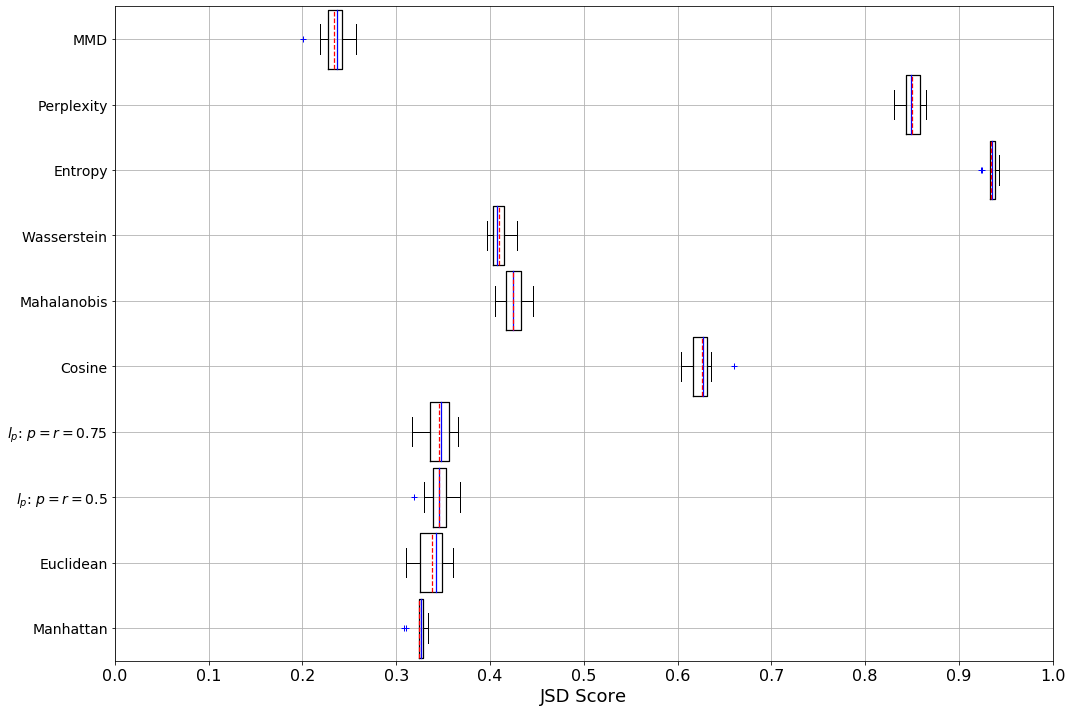

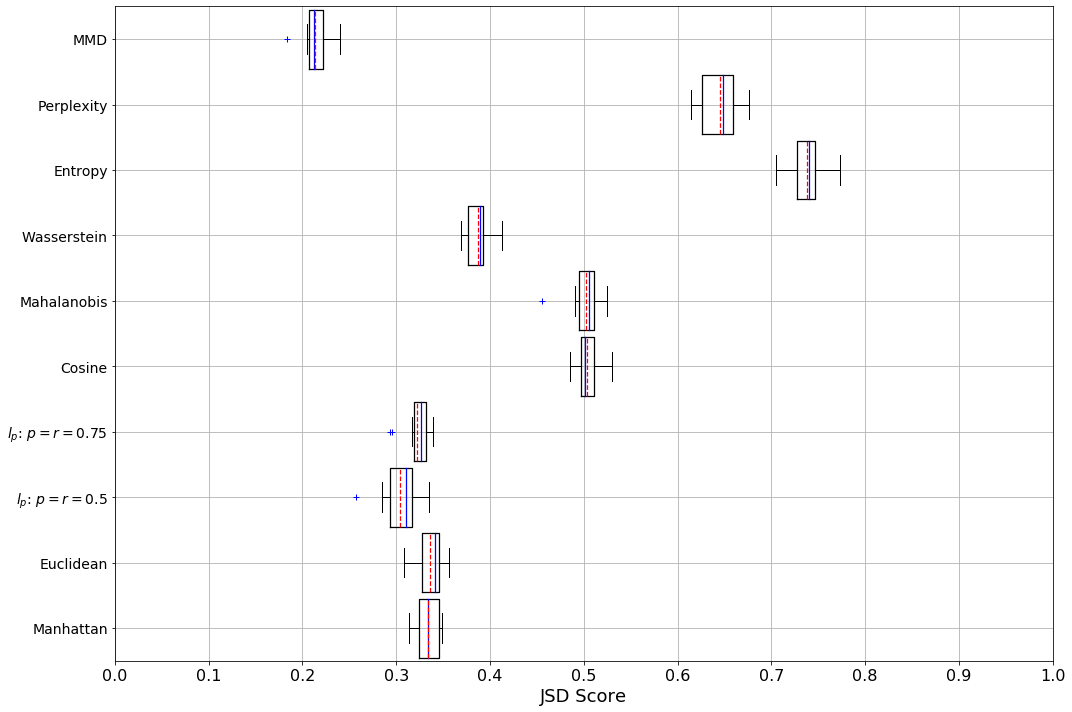

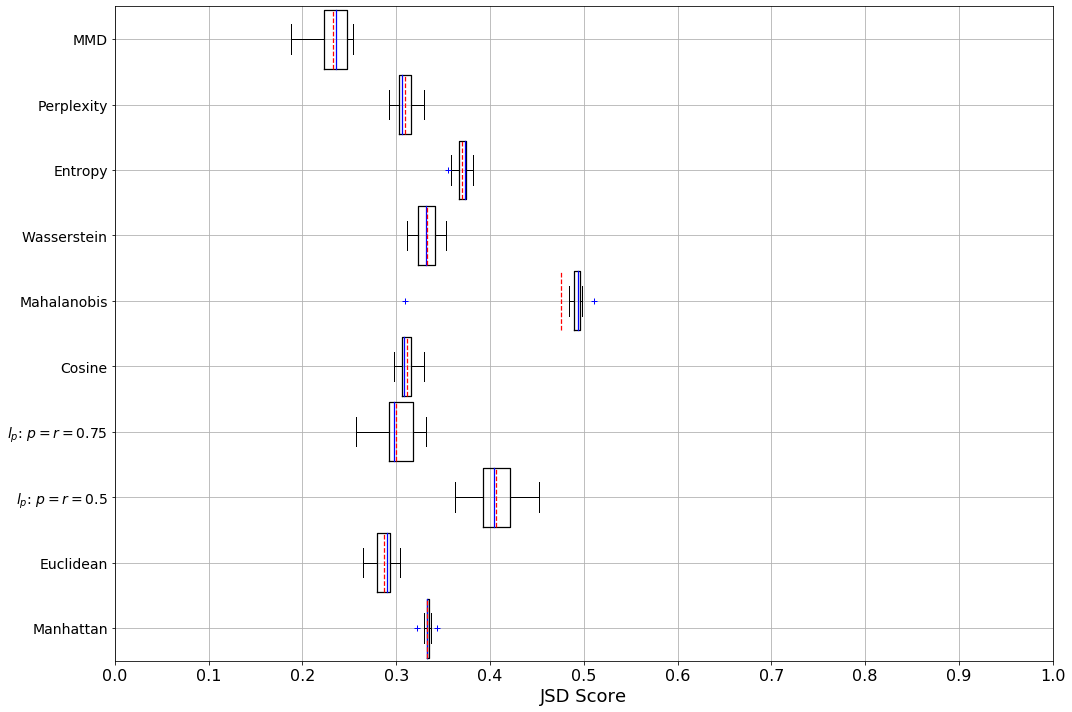

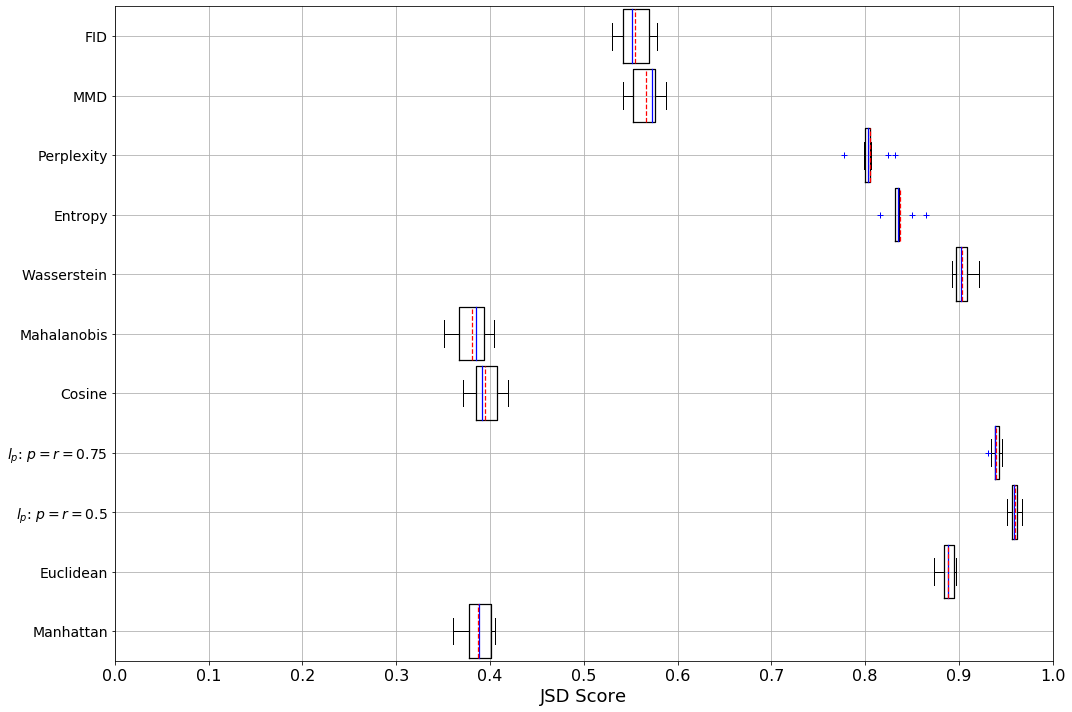

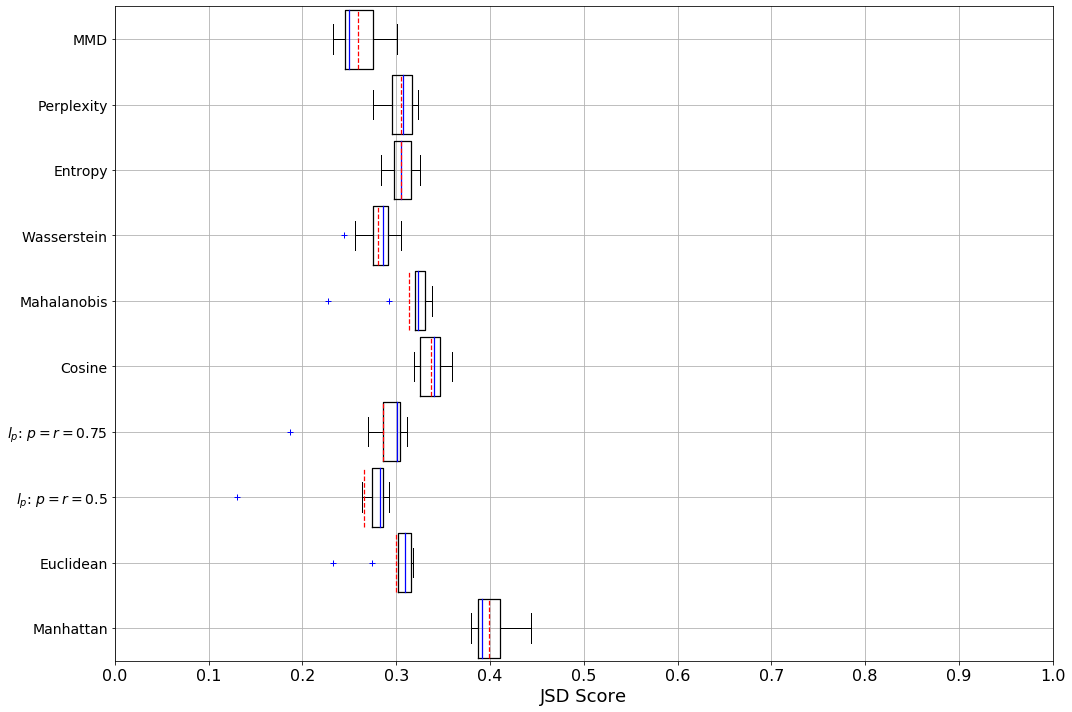

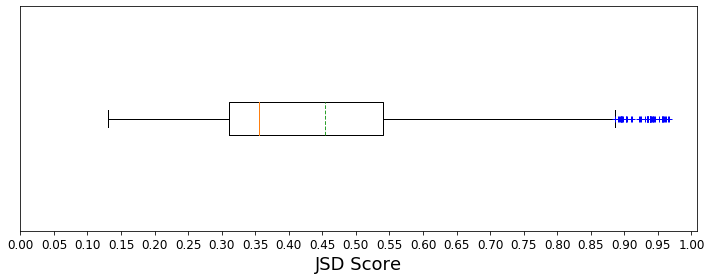

In [97]:
results_list = ['JSD_results_untrans.csv', 'JSD_results_sqrt.csv', 'JSD_results_log.csv', 'JSD_results_pca.csv', 'JSD_results_fft.csv']
#names = ['Manhattan', 'Euclidean',  r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD', 'FID']

transforms = ['untrans', 'sqrt', 'log', 'pca', 'fft']
results_df = pd.DataFrame()
counter = 0
for file_name in results_list:
    names = ['Euclidean', 'Manhattan', r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD', 'FID']
    if 'pca' not in file_name:
        names = names[:10]
    df = pd.read_csv('results/'+file_name)
    temp = df.loc[:,'Run 1':'Run 10'].T
    results_df = results_df.append(temp)
    fig2 = plt.figure(figsize=(15,10))
    temp.columns = names
    bp = temp.boxplot( meanline=True, showmeans=True, vert=False, sym='b+', widths=0.9, return_type='dict')
    for median in bp['medians']:
        median.set(color='b', linewidth=1.25)
    for mean in bp['means']:
        mean.set(color='r', linewidth=1.25)
    for box in bp['boxes']:
        box.set(color='k',linewidth=1.25)
    for whisker in bp['whiskers']:
        whisker.set(color='k',linewidth=1.0)
    for cap in bp['caps']:
        cap.set(color='k',linewidth=1.0)
    plt.xlabel("JSD Score", fontsize=18)
    plt.xticks(np.arange(0,1.01,0.1),fontsize=16)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    plt.savefig('/home/mnewlin/git/AFIT/Thesis/code/figures/discriminative/eps/box_whisker_network_{}.pdf'.format(transforms[counter]))
    plt.show()
    counter += 1
all_results_array = results_df.to_numpy().flatten()
all_results_array = all_results_array[~np.isnan(all_results_array)]
fig = plt.figure(figsize=(10,4))
plt.boxplot(all_results_array, meanline=True, showmeans=True, vert=False, sym='b+')
plt.xticks(np.arange(0,1.01,0.05), fontsize=12)
plt.yticks([])
plt.xlabel("JSD Score", fontsize=18)
plt.tight_layout()
plt.savefig('/home/mnewlin/git/AFIT/Thesis/code/figures/discriminative/eps/box_whisker_network.pdf')
plt.savefig('/home/mnewlin/git/AFIT/Thesis/code/figures/discriminative/png/box_whisker_network.png')
plt.show()

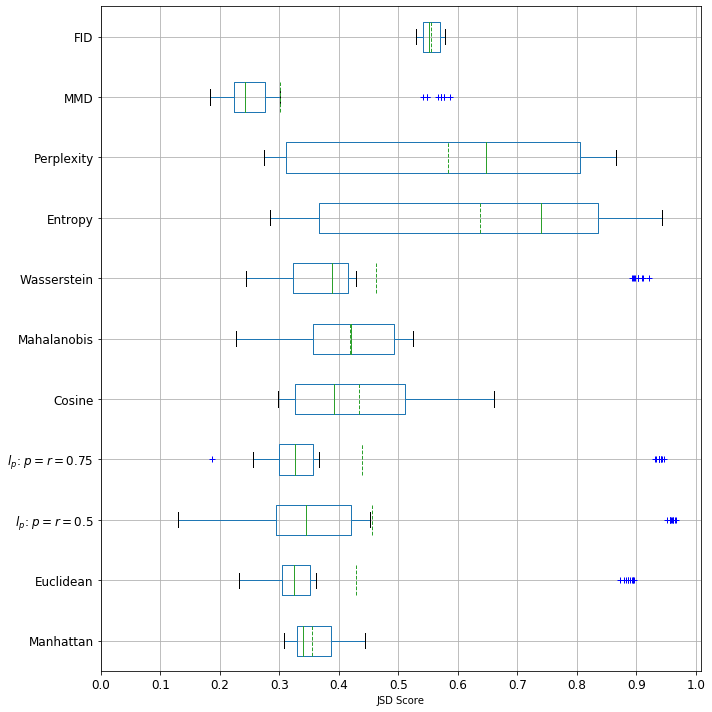